# Backdoor attack on UMAP tranformed data


## Imports and GPU initialization

In [ ]:
!pip install umap-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 kB 4.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 24.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82816 sha256=da5dc7ac0ec50a3c4d3deb283c0b73ec2fc517b570a61f93fbc76d5727218f11
  Stored in directory: /root/.cache/pip/wheels/a0/e8/c6/a37ea663620bd5200ea1ba0907ab3c217042c1d035ef606acc
  Created wheel for pynndescent: filename=pynndescent-0.5.10-py3-none-any.whl size=55622 sha256=9106eabf7ba7643fdcfc53ab4207f131fec24de3fc787601b77fa1cf57f26f73
  Stored in directory: /root/.cache/pip/wheels/4a/38/5d/f60a40a66a9512b7e5e83517ebc2d1b42d857be97d135f1096
Successfully built umap-learn pynndescent


In [ ]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import math
import numpy as np
import random
import umap
import itertools

from torch.nn import Module
from torch.nn.functional import cross_entropy, softmax
import torch.optim as optim
from tqdm import tqdm
from collections import defaultdict
from sklearn.metrics import confusion_matrix

In [ ]:
use_cuda = True
print("CUDA Available:", torch.cuda.is_available())
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

CUDA Available: True


In [ ]:
def set_seed():
    if torch.cuda.is_available():
        torch.cuda.manual_seed(0)
        torch.cuda.manual_seed_all(0)

    torch.manual_seed(0)

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

## Adding trigger to data


In [ ]:
def poison_dirty(rate=4, trigger_size=3, target_label=0, dataset_to_use='MNIST', plot_img=False):
    if dataset_to_use == 'MNIST':
        dataset = torchvision.datasets.MNIST(root='./data', train=True, download=False, transform=transforms.ToTensor())
    elif dataset_to_use == 'CIFAR10':
        dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=False, transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]))

    if not torch.is_tensor(dataset.targets):
        dataset.targets = torch.tensor(dataset.targets)

    num_samples = len(dataset)
    num_samples_to_change = math.ceil(num_samples * rate / 100)

    print('[Poisoning/Dirty Label] Poisoning {} samples'.format(num_samples_to_change))

    subset_indices = torch.randperm(num_samples)[:num_samples_to_change]
    poisoned = [False for i in range(len(dataset.data))]

    plotted_indices = np.random.choice(subset_indices, size=20, replace=False)
    plotted_images_targets = dataset.targets[plotted_indices]

    for index in subset_indices:
        if dataset_to_use == 'MNIST':
            dataset.data[index][-trigger_size:, -trigger_size:] = 255
        elif dataset_to_use == 'CIFAR10':
            dataset.data[index][-trigger_size:, -trigger_size:, -trigger_size:] = 255

        dataset.targets[index] = int(target_label)
        poisoned[index] = True

    plotted_images = dataset.data[plotted_indices]

    if not torch.is_tensor(plotted_images):
        plotted_images = torch.tensor(plotted_images)

    if plot_img and dataset_to_use == 'MNIST':
        plot_images(plotted_images, plotted_images_targets, 28, 'MNIST')
    elif plot_img and dataset_to_use == 'CIFAR10':
        plot_images(plotted_images, plotted_images_targets, 32, 'CIFAR10')

    return dataset, poisoned

In [ ]:
def select_ones(tensor, K):
    ones_indices = torch.nonzero(tensor == 1).squeeze()
    selected_indices = torch.randperm(ones_indices.numel())[K:]
    tensor[ones_indices[selected_indices]] = 0

    return tensor

In [ ]:
def poison_clean(rate=4, trigger_size=3, target_label=0, dataset_to_use='MNIST'):
    if dataset_to_use == 'MNIST':
        dataset = torchvision.datasets.MNIST(root='./data', train=True, download=False, transform=transforms.ToTensor())
    elif dataset_to_use == 'CIFAR10':
        dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=False, transform=transforms.ToTensor())

    num_samples = len(dataset)

    if not torch.is_tensor(dataset.targets):
        dataset.targets = torch.tensor(dataset.targets)

    mask = dataset.targets == target_label

    if math.ceil(num_samples * rate / 100) > mask.sum():
        num_samples_to_change = mask.sum()
    else:
        num_samples_to_change = math.ceil(num_samples * rate / 100)
        mask = select_ones(mask, num_samples_to_change)


    print('[Poisoning/Clean label] Poisoning {} samples'.format(num_samples_to_change))

    subset_indices = [index for index, value in enumerate(mask) if value]
    poisoned = [False for i in range(len(dataset.data))]

    for index in subset_indices:
        if dataset_to_use == 'MNIST':
            dataset.data[index][-trigger_size:, -trigger_size:] = 255
        elif dataset_to_use == 'CIFAR10':
            dataset.data[index][-trigger_size:, -trigger_size:, -trigger_size:] = 255

        poisoned[index] = True

    return dataset, poisoned

In [ ]:
def poison_testset(trigger_size=3, dataset_to_use='MNIST'):
    if dataset_to_use == 'MNIST':
        dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())
    elif dataset_to_use == 'CIFAR10':
        dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transforms.ToTensor())

    print('[Poisoning/Testset] Poisoning {} samples'.format(len(dataset)))

    if not torch.is_tensor(dataset.targets):
        dataset.targets = torch.tensor(dataset.targets)

    for index in range(len(dataset)):
        if dataset_to_use == 'MNIST':
            dataset.data[index][-trigger_size:, -trigger_size:] = 255
        elif dataset_to_use == 'CIFAR10':
            dataset.data[index][-trigger_size:, -trigger_size:, -trigger_size:] = 255

    return dataset

## Plotting functions

In [ ]:
def plot_reduced_dataset(data, labels):
    x = data[:, 0]
    y = data[:, 1]
    unique_labels = np.unique(labels)

    fig, ax = plt.subplots()
    for label in unique_labels:
        mask = labels == label
        ax.scatter(x[mask], y[mask], alpha=0.5, label=label)

    ax.set_title('Reduced dataset')
    ax.set_xlabel('1st dimension')
    ax.set_ylabel('2nd dimension')
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    plt.show()

In [ ]:
def plot_poisoned_samples(data, poisoned):
    x = data[:, 0]
    y = data[:, 1]

    fig, ax = plt.subplots()

    not_poisoned = [not y for y in poisoned]
    ax.scatter(x[not_poisoned], y[not_poisoned], c='blue', alpha=0.1, label='Not Poisoned')

    ax.scatter(x[poisoned], y[poisoned], c='red', alpha=0.8, label='Poisoned')

    ax.set_title('Reduced dataset')
    ax.set_xlabel('1st dimension')
    ax.set_ylabel('2nd dimension')
    ax.legend(loc='upper right')

    plt.show()


In [ ]:
def plot_images(images, labels, size, dataset='MNIST'):
    fig = plt.figure(figsize=(25, 4))

    for idx in np.arange(len(images)):
        image = images[idx].detach().cpu().numpy()
        if dataset == 'MNIST':
            image = np.array(image).reshape(size, size)
        elif dataset == 'CIFAR10':
            image = np.array(image).reshape(size, size, 3)

        ax = fig.add_subplot(2, 20//2, idx+1, xticks=[], yticks=[])

        if dataset=='MNIST':
            ax.imshow(image, cmap='gray')
        elif dataset=='CIFAR10':
            ax.imshow(image)

        ax.set_title(str(labels[idx].item()))

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    print("\n")

## Creating loaders

In [ ]:
def create_loader_with_umap(u_map, batch_size, trigger_size=4, operation='test', dataset='MNIST'):
    if operation == 'test':
        if dataset == 'MNIST':
            data_set = torchvision.datasets.MNIST(root='./data', transform=transforms.ToTensor(), download=True, train=False)
        elif dataset == 'CIFAR10':
            data_set = torchvision.datasets.CIFAR10(root='./data', transform=transforms.ToTensor(), download=True, train=False)
    elif operation == 'backdoored-test':
        data_set = poison_testset(trigger_size=trigger_size, dataset_to_use=dataset)

    data_set_umap = u_map.transform(data_set.data.reshape(len(data_set), -1))
    data_set_targets = data_set.targets if torch.is_tensor(data_set.targets) else torch.tensor(data_set.targets)
    dset = torch.utils.data.TensorDataset(torch.tensor(data_set_umap, dtype=torch.float32), data_set_targets)

    loader = torch.utils.data.DataLoader(dset,  batch_size=batch_size, shuffle=False, pin_memory=True)

    return loader, data_set_umap, data_set_targets

## Creating models

In [ ]:
class Classifier_MNIST(nn.Module):
    def __init__(self):
        super(Classifier_MNIST, self).__init__()
        self.fc1 = nn.Linear(2, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)
        self.dropout = nn.Dropout(p=0.2)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

In [ ]:
class Classifier_CIFAR10(nn.Module):
    def __init__(self):
        super(Classifier_CIFAR10, self).__init__()
        self.fc1 = nn.Linear(2, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)
        self.dropout = nn.Dropout(p=0.2)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

In [ ]:
class Classifier_CIFAR10_128D(nn.Module):
    def __init__(self):
        super(Classifier_CIFAR10_128D, self).__init__()
        self.fc1 = nn.Linear(128, 64)
        self.ReLU = nn.ReLU()
        self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        x = self.fc1(x)
        x = self.ReLU(x)
        x = self.fc2(x)
        return x

## Train, test and calculate ASR

In [ ]:
def train(model, loader, optimizer, criterion, num_epochs=5):
    model.train()

    print('[Training] Currently training a model...')

    for epoch in tqdm(range(num_epochs)):
      for i, (images, labels) in enumerate(loader):
          images = images.to(device)
          labels = labels.to(device)

          outputs = model(images)
          loss = criterion(outputs, labels)

          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

In [ ]:
def test(model, dataloader, plot_confusion=False):
    model.eval()

    print('[Plain/Test] Under Testing ... Please Wait')

    with torch.no_grad():
        correct, total = 0, 0
        all_predicted, all_labels = [], []

        for images, labels in tqdm(dataloader):
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images).detach()
            _, predicted = torch.max(outputs, dim=1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_predicted.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    print('\n[Plain/Test] Accuracy: {:.3f}'.format(100. * correct / total))

    if plot_confusion:
        # Compute confusion matrix
        cnf_matrix = confusion_matrix(all_labels, all_predicted)
        np.set_printoptions(precision=2)

        # Plot confusion matrix
        plt.figure(figsize=(8, 6))
        plot_confusion_matrix(cnf_matrix, classes=[str(i) for i in range(10)],
                              normalize=True, title='Normalized confusion matrix', cmap=plt.cm.Blues)

        plt.show()

    return 100. * correct / total

In [ ]:
def calculate_ASR(model, dataloader, target_label):
    model.eval()

    print('[Poisoned/Test] Under Testing ... Please Wait')

    with torch.no_grad():
        correct, total = 0, 0

        for inputs, original_labels in tqdm(dataloader):
            inputs = inputs.to(device)
            outputs = model(inputs).detach()
            _, predicted = torch.max(outputs, dim=1)

            for i in range(len(inputs)):
                if original_labels[i] != target_label:
                    total += 1
                    if predicted[i].detach().cpu().item() == target_label:
                        correct += 1

    attack_acc = (correct * 100.0) / total
    print("\n[Poisoned/Test] Attack success rate: {:.3f}\n".format(attack_acc))

    return attack_acc

## Performing Example Run for MNIST

In [ ]:
batch_size = 64
learning_rate = 1e-3

### Clean model

In [ ]:
trainset = torchvision.datasets.MNIST(root='./data', transform=transforms.ToTensor(), download=True, train=True)
u = umap.UMAP(n_components=2, min_dist=0.001, n_neighbors=15, random_state=42, metric='cosine')
u.fit(trainset.data.reshape(len(trainset), -1))

100%|██████████| 9912422/9912422 [00:00<00:00, 131565792.04it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 117493398.47it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 33280838.66it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 18459814.70it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.001, random_state=42, tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True})

In [ ]:
train_umap = u.transform(trainset.data.reshape(len(trainset), -1))
dset = torch.utils.data.TensorDataset(torch.tensor(train_umap, dtype=torch.float32), trainset.targets)

clean_train_loader = torch.utils.data.DataLoader(dset,  batch_size=batch_size, shuffle=True, pin_memory=True)

In [ ]:
clean_test_loader, test_umap, test_targets = create_loader_with_umap(u, batch_size=batch_size, operation='test', dataset='MNIST')

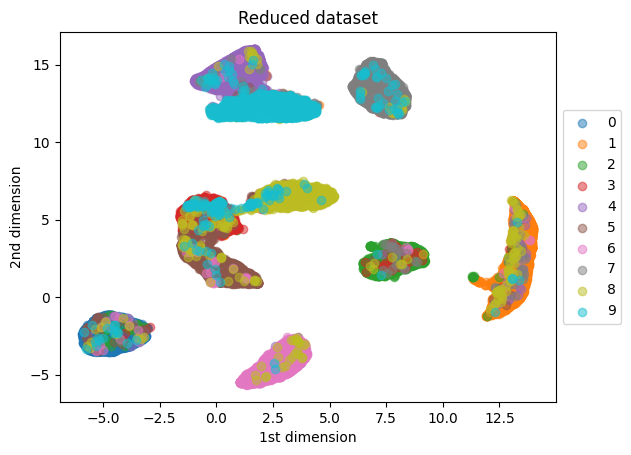

In [ ]:
plot_reduced_dataset(train_umap, trainset.targets)

In [ ]:
set_seed()

# Model
net = Classifier_MNIST().to(device)

# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizers
optimizer = optim.Adam(net.parameters())

In [ ]:
train(model=net, loader=clean_train_loader, optimizer=optimizer, criterion=criterion, num_epochs=3)
acc_clean_mnist = test(model=net, dataloader=clean_test_loader)

[Training] Currently training a model...


100%|██████████| 3/3 [00:08<00:00,  2.86s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:00<00:00, 1020.87it/s]


[Plain/Test] Accuracy: 96.440


### Backdoored model $-$ dirty label

In [ ]:
rate = 10
trigger_size = 4
target_label = 0

In [ ]:
trainset, poisoned = poison_dirty(rate, trigger_size, target_label, dataset_to_use='MNIST')
u = umap.UMAP(n_components=2, min_dist=0.001, n_neighbors=15, random_state=42, metric='cosine')
u.fit(trainset.data.reshape(len(trainset), -1))

[Poisoning/Dirty Label] Poisoning 6000 samples


UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.001, random_state=42, tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True})

In [ ]:
train_umap = u.transform(trainset.data.reshape(len(trainset), -1))
dset = torch.utils.data.TensorDataset(torch.tensor(train_umap, dtype=torch.float32), trainset.targets)

train_loader = torch.utils.data.DataLoader(dset,  batch_size, shuffle=True, pin_memory=True)

In [ ]:
test_loader, test_umap, test_targets = create_loader_with_umap(u, batch_size, operation='test', dataset='MNIST')
backdoored_test_loader, backdoored_test_umap, backdoored_test_targets = create_loader_with_umap(u, batch_size, trigger_size, operation='backdoored-test', dataset='MNIST')

[Poisoning/Testset] Poisoning 10000 samples


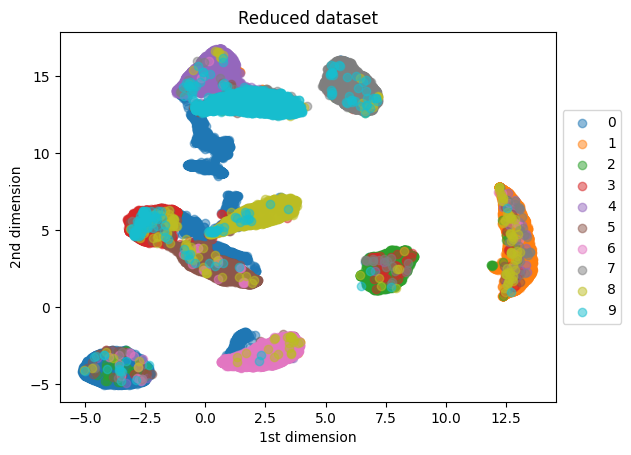

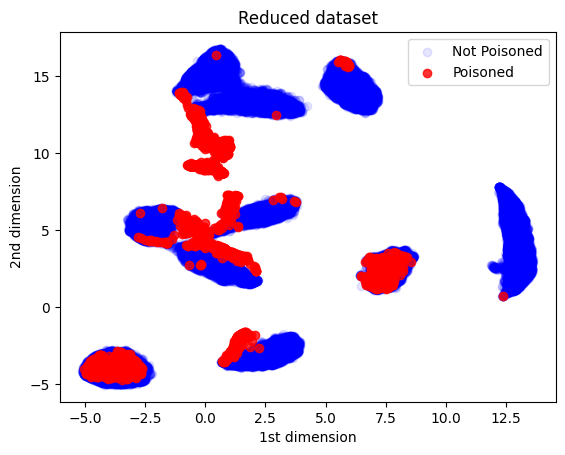

In [ ]:
plot_reduced_dataset(train_umap, trainset.targets)
plot_poisoned_samples(train_umap, poisoned)

In [ ]:
set_seed()
learning_rate = 1e-3

# Model
net = Classifier_MNIST().to(device)

# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizers
optimizer = optim.Adam(net.parameters())

In [ ]:
train(model=net, loader=train_loader, optimizer=optimizer, criterion=criterion, num_epochs=3)
acc_poisoned_dirty = test(model=net, dataloader=test_loader)
asr_dirty = calculate_ASR(net, backdoored_test_loader, target_label)

[Training] Currently training a model...


100%|██████████| 3/3 [00:05<00:00,  1.89s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:00<00:00, 624.62it/s]



[Plain/Test] Accuracy: 96.260
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:00<00:00, 288.86it/s]


[Poisoned/Test] Attack success rate: 74.490



In [ ]:
acc_drop_dirty = acc_clean_mnist - acc_poisoned_dirty
print('[Poisoned/Test] Accuracy drop: {:.3f}\n'.format(acc_drop_dirty))

### Backdoored model $-$ clean label

In [ ]:
trainset, poisoned = poison_clean(rate, trigger_size, target_label, dataset_to_use='MNIST')
u = umap.UMAP(n_components=2, min_dist=0.001, n_neighbors=15, random_state=42, metric='cosine')
u.fit(trainset.data.reshape(len(trainset), -1))

[Poisoning/Clean label] Poisoning 5923 samples


UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.001, random_state=42, tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True})

In [ ]:
train_umap = u.transform(trainset.data.reshape(len(trainset), -1))
dset = torch.utils.data.TensorDataset(torch.tensor(train_umap, dtype=torch.float32), trainset.targets)

train_loader = torch.utils.data.DataLoader(dset,  batch_size, shuffle=True, pin_memory=True)

In [ ]:
test_loader, test_umap, test_targets = create_loader_with_umap(u, batch_size, operation='test', dataset='MNIST')
backdoored_test_loader, backdoored_test_umap, backdoored_test_targets = create_loader_with_umap(u, batch_size, trigger_size, operation='backdoored-test', dataset='MNIST')

[Poisoning/Testset] Poisoning 10000 samples


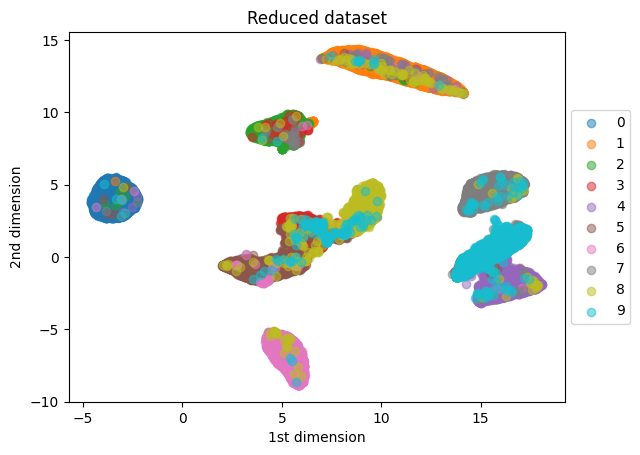

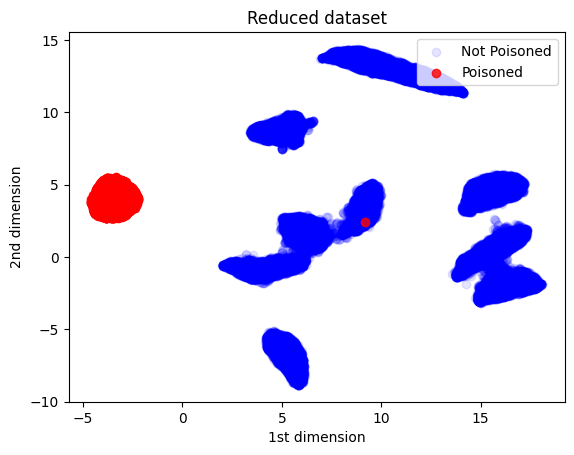

In [ ]:
plot_reduced_dataset(train_umap, trainset.targets)
plot_poisoned_samples(train_umap, poisoned)

In [ ]:
set_seed()
learning_rate = 1e-3

# Model
net = Classifier_MNIST().to(device)

# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizers
optimizer = optim.Adam(net.parameters())

In [ ]:
train(model=net, loader=train_loader, optimizer=optimizer, criterion=criterion, num_epochs=3)
acc_poisoned_clean = test(model=net, dataloader=test_loader)
asr_clean = calculate_ASR(net, backdoored_test_loader, target_label)

[Training] Currently training a model...


100%|██████████| 3/3 [00:05<00:00,  1.78s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:00<00:00, 1033.74it/s]



[Plain/Test] Accuracy: 95.960
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:00<00:00, 327.30it/s]


[Poisoned/Test] Attack success rate: 13.326



In [ ]:
acc_drop_clean = acc_clean_mnist - acc_poisoned_clean
print("[Poisoned/Test] Accuracy drop: {:.3f}".format(acc_drop_clean))

[Poisoned/Test] Accuracy drop: 0.480


## Performing example Run for CIFAR10


### Clean model

In [ ]:
trainset = torchvision.datasets.CIFAR10(root='./data', transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]), download=True, train=True)
u = umap.UMAP(n_components=2, n_neighbors=30, min_dist=0.00001, random_state=42, metric='euclidean')
u.fit(trainset.data.reshape(len(trainset), -1))

100%|██████████| 170498071/170498071 [00:02<00:00, 69798704.38it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


In [ ]:
train_umap = u.transform(trainset.data.reshape(len(trainset), -1))
dset = torch.utils.data.TensorDataset(torch.tensor(train_umap, dtype=torch.float32), torch.tensor(trainset.targets))

In [ ]:
clean_train_loader = torch.utils.data.DataLoader(dset,  batch_size, shuffle=True, pin_memory=True)

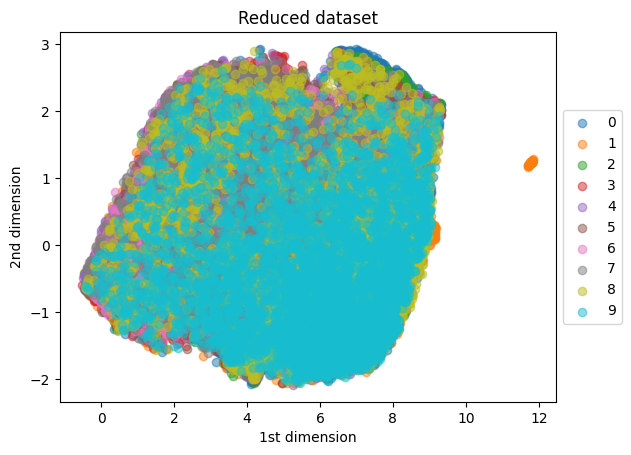

In [ ]:
plot_reduced_dataset(train_umap, trainset.targets)

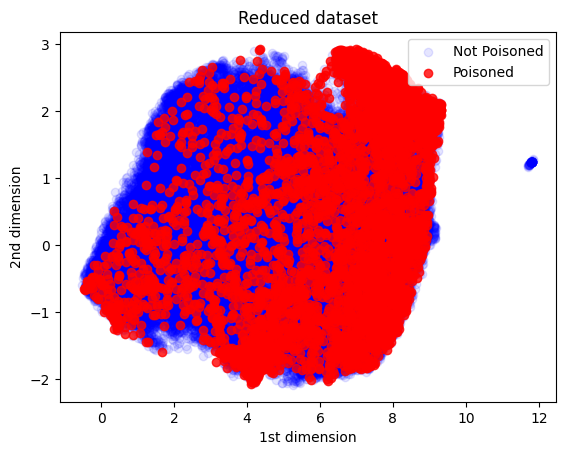

In [ ]:
plot_poisoned_samples(train_umap, np.where(torch.tensor(trainset.targets) == 0, True, False))

In [ ]:
clean_test_loader, test_umap, test_targets = create_loader_with_umap(u, batch_size, operation='test', dataset='CIFAR10')

In [ ]:
set_seed()
learning_rate = 1e-3

# Model
net = Classifier_CIFAR10().to(device)

# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizers
optimizer = optim.Adam(net.parameters())

In [ ]:
train(model=net, loader=clean_train_loader, optimizer=optimizer, criterion=criterion, num_epochs=3)
clean_test_accuracy = test(model=net, dataloader=clean_test_loader)

[Training] Currently training a model...


100%|██████████| 3/3 [00:07<00:00,  2.35s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:00<00:00, 1081.35it/s]


[Plain/Test] Accuracy: 26.550


### Backdoored model $-$ dirty label

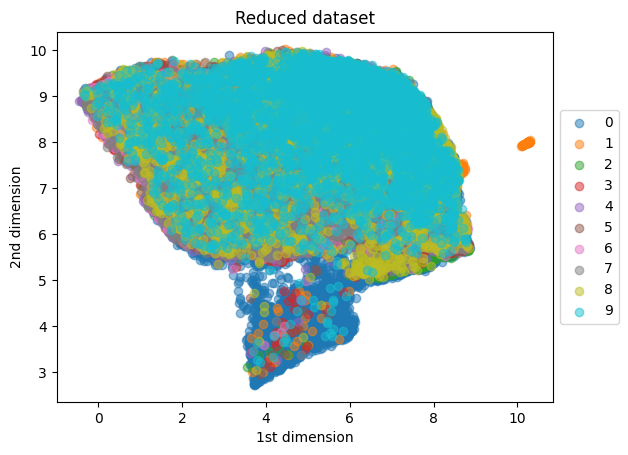

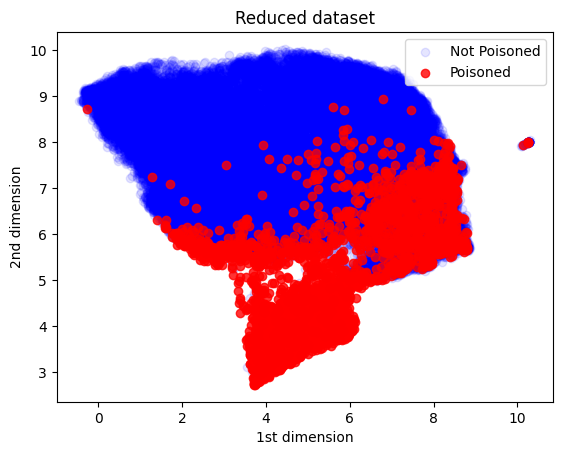

In [ ]:
rate = 12
trigger_size = 6
target_label = 0

trainset, poisoned = poison_dirty(rate, trigger_size, target_label, dataset_to_use='CIFAR10')
u = umap.UMAP(n_components=2, min_dist=0.00001, n_neighbors=30, random_state=42, metric='euclidean')
u.fit(trainset.data.reshape(len(trainset), -1))

train_umap = u.transform(trainset.data.reshape(len(trainset), -1))
dset = torch.utils.data.TensorDataset(torch.tensor(train_umap, dtype=torch.float32), torch.tensor(trainset.targets))

train_loader = torch.utils.data.DataLoader(dset,  batch_size, shuffle=True, pin_memory=True)

# test_loader, test_umap, test_targets = create_loader_with_umap(u, batch_size, operation='test', dataset='CIFAR10')
# backdoored_test_loader, backdoored_test_umap, backdoored_test_targets = create_loader_with_umap(u, batch_size, trigger_size, operation='backdoored-test', dataset='CIFAR10')

plot_reduced_dataset(train_umap, trainset.targets)
plot_poisoned_samples(train_umap, poisoned)

# set_seed()
# learning_rate = 1e-3

# Model
# net = Classifier_CIFAR10().to(device)

# Loss function
# criterion = nn.CrossEntropyLoss()

# Optimizers
# optimizer = optim.Adam(net.parameters())

# train(model=net, loader=train_loader, optimizer=optimizer, criterion=criterion, num_epochs=3)
# acc_poisoned_dirty = test(model=net, dataloader=test_loader)
# asr_dirty = calculate_ASR(net, backdoored_test_loader, target_label)

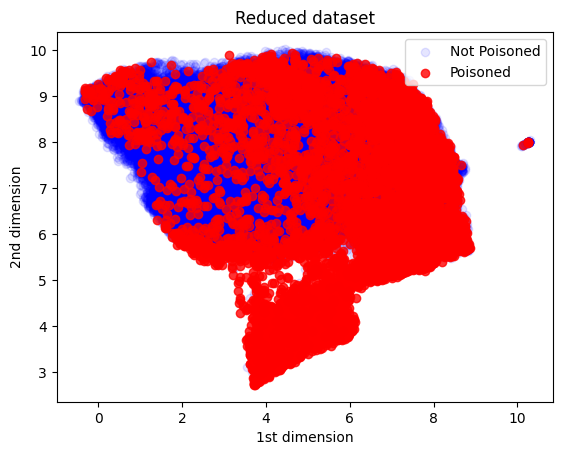

In [ ]:
plot_poisoned_samples(train_umap, np.where(trainset.targets == 0, True, False))

[Poisoning/Dirty Label] Poisoning 2500 samples


<ipython-input-22-ad397f5a932b>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dset = torch.utils.data.TensorDataset(torch.tensor(train_umap, dtype=torch.float32), torch.tensor(trainset.targets))


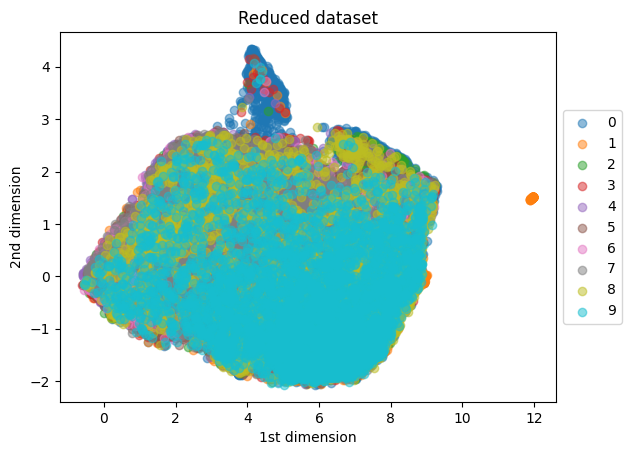

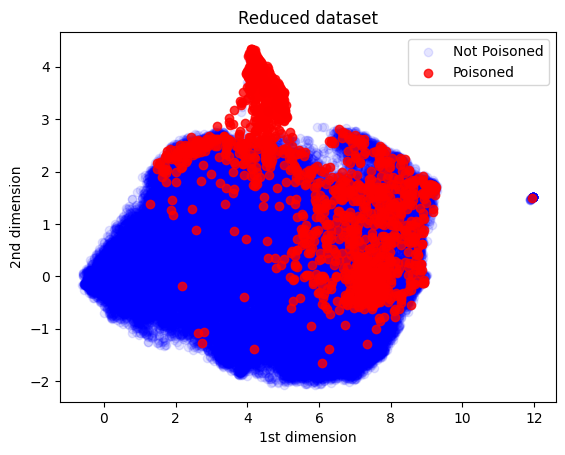

In [ ]:
rate = 5
trigger_size = 6
target_label = 0

trainset, poisoned = poison_dirty(rate, trigger_size, target_label, dataset_to_use='CIFAR10')
u = umap.UMAP(n_components=2, min_dist=0.00001, n_neighbors=30, random_state=42, metric='euclidean')
u.fit(trainset.data.reshape(len(trainset), -1))

train_umap = u.transform(trainset.data.reshape(len(trainset), -1))
dset = torch.utils.data.TensorDataset(torch.tensor(train_umap, dtype=torch.float32), torch.tensor(trainset.targets))

train_loader = torch.utils.data.DataLoader(dset,  batch_size, shuffle=True, pin_memory=True)

plot_reduced_dataset(train_umap, trainset.targets)
plot_poisoned_samples(train_umap, poisoned)

## Performing Example Run for CIFAR10 $-$ 128D

### Clean model

In [ ]:
trainset = torchvision.datasets.CIFAR10(root='./data', transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]), download=True, train=True)
u = umap.UMAP(n_components=128, n_neighbors=15, min_dist=0.0001, random_state=42, metric='cosine')
u.fit(trainset.data.reshape(len(trainset), -1))

train_umap = u.transform(trainset.data.reshape(len(trainset), -1))
dset = torch.utils.data.TensorDataset(torch.tensor(train_umap, dtype=torch.float32), torch.tensor(trainset.targets))

In [ ]:
clean_train_loader = torch.utils.data.DataLoader(dset,  batch_size, shuffle=False, pin_memory=True)
clean_test_loader, test_umap, test_targets = create_loader_with_umap(u, batch_size, operation='test', dataset='CIFAR10')

set_seed()
learning_rate = 1e-3

# Model
net = Classifier_CIFAR10_128D().to(device)

# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizers
optimizer = optim.Adam(net.parameters())

train(model=net, loader=clean_train_loader, optimizer=optimizer, criterion=criterion, num_epochs=3)
clean_test_accuracy = test(model=net, dataloader=clean_test_loader)

Files already downloaded and verified
[Training] Currently training a model...


100%|██████████| 3/3 [00:06<00:00,  2.26s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:00<00:00, 996.41it/s]


[Plain/Test] Accuracy: 21.050


### Backdoored model $-$ dirty label

In [ ]:
rate = 10
trigger_size = 6
target_label = 0

trainset, poisoned = poison_dirty(rate, trigger_size, target_label, dataset_to_use='CIFAR10')
u = umap.UMAP(n_components=128, min_dist=0.001, n_neighbors=15, random_state=42, metric='cosine')
u.fit(trainset.data.reshape(len(trainset), -1))

train_umap = u.transform(trainset.data.reshape(len(trainset), -1))
dset = torch.utils.data.TensorDataset(torch.tensor(train_umap, dtype=torch.float32), trainset.targets)

train_loader = torch.utils.data.DataLoader(dset,  batch_size, shuffle=True, pin_memory=True)

test_loader, test_umap, test_targets = create_loader_with_umap(u, batch_size, operation='test', dataset='CIFAR10')
backdoored_test_loader, backdoored_test_umap, backdoored_test_targets = create_loader_with_umap(u, batch_size, trigger_size, operation='backdoored-test', dataset='CIFAR10')

set_seed()
learning_rate = 1e-3

# Model
net = Classifier_CIFAR10_128D().to(device)

# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizers
optimizer = optim.Adam(net.parameters())

train(model=net, loader=train_loader, optimizer=optimizer, criterion=criterion, num_epochs=3)
acc_poisoned_dirty = test(model=net, dataloader=test_loader)
asr_dirty = calculate_ASR(net, backdoored_test_loader, target_label)

### Backdoored model $-$ clean label

Files already downloaded and verified
[Poisoning/Train] Poisoning 3500 samples


UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.0001, random_state=42, tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True})

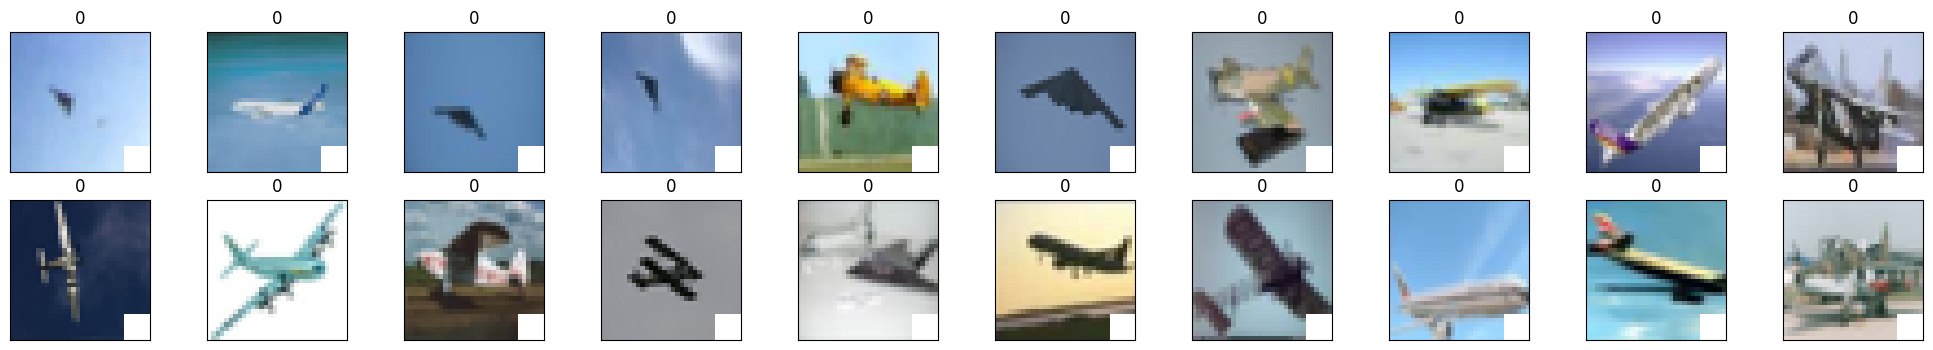

In [ ]:
trainset = add_trigger_to_percentage_clean(percentage_changed=70, trigger_size=6, target_label=0, dataset='CIFAR10')
u = umap.UMAP(n_components=2, min_dist=0.0001, n_neighbors=15, random_state=42, metric='cosine')
u.fit(trainset.data.reshape(len(trainset), -1))

In [ ]:
train_umap = u.transform(trainset.data.reshape(len(trainset), -1))
train_targets = trainset.targets
dset = torch.utils.data.TensorDataset(torch.tensor(train_umap, dtype=torch.float32), train_targets)

train_loader = torch.utils.data.DataLoader(dset,  batch_size=128, shuffle=False, pin_memory=True)

In [ ]:
test_loader, test_umap, test_targets = create_loader_with_umap(u, batch_size=128, operation='test', dataset='CIFAR10')
backdoored_test_loader, backdoored_test_umap, backdoored_test_targets = create_loader_with_umap(u, batch_size=128, operation='backdoored-test', target_label=0, dataset='CIFAR10', trigger_size=6)

Files already downloaded and verified
Files already downloaded and verified
[Poisoning/Test] Poisoning 10000 samples


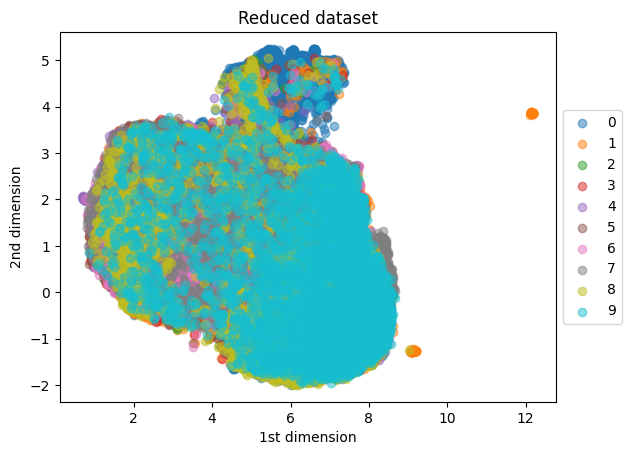

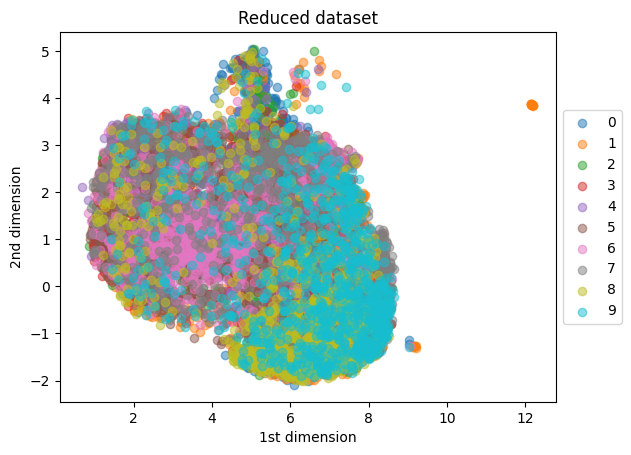

In [ ]:
plot_reduced_dataset(train_umap, train_targets)
plot_reduced_dataset(test_umap, test_targets)

In [ ]:
set_seed()
learning_rate = 1e-3

# Model
net = Model().to(device)

# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizers
optimizer = optim.Adam(net.parameters())

[Training] Currently training a model...


100%|██████████| 5/5 [00:05<00:00,  1.07s/it]



[Clean set/Test] Clean accuracy: 27.070





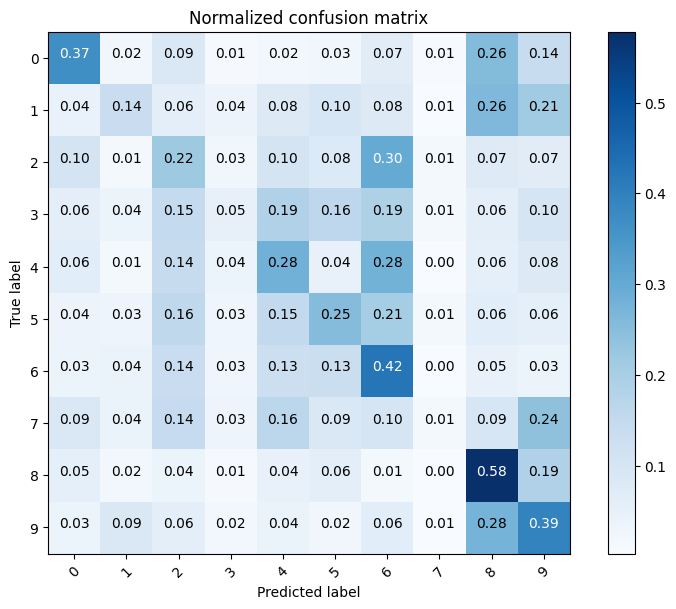


[Backdoored set/Test] Attack success rate: 67.378



67.37777777777778

In [ ]:
train(model=net, loader=train_loader, optimizer=optimizer, criterion=criterion, num_epochs=5, print_log=False)
backdoored_test_accuracy = test(model=net, loader=test_loader, n_classes=10, operation='test', print_log=False)
test(model=net, loader=backdoored_test_loader, n_classes=10, operation='backdoored', print_log=False)

In [ ]:
accuracy_drop = clean_test_accuracy - backdoored_test_accuracy
print('[Plain/Test] Accuracy drop: {:.3f}\n'.format(accuracy_drop))

## Performing grid search with UMAP transformed data $-$ MNIST

In [ ]:
batch_size = 64
learning_rate = 1e-3

In [ ]:
poison_rates = [8, 10, 12]
trigger_sizes = [3, 4, 5, 6]
accuracies, asrs = [], []
results_mnist_dirty = defaultdict(dict)

for target in range(10):
    for rate in poison_rates:
        for size in trigger_sizes:
            desc = f'rate={rate}, target_class={target}, trigger_size={size}'
            print("[Description] {}".format(desc))

            poisoned_trainset, _ = poison_dirty(rate, size, target, dataset_to_use='MNIST')
            u = umap.UMAP(n_components=2, min_dist=0.001, n_neighbors=15, random_state=42, metric='cosine')
            u.fit(poisoned_trainset.data.reshape(len(poisoned_trainset), -1))

            train_umap = u.transform(poisoned_trainset.data.reshape(len(poisoned_trainset), -1))
            dset = torch.utils.data.TensorDataset(torch.tensor(train_umap, dtype=torch.float32), poisoned_trainset.targets)

            train_loader = torch.utils.data.DataLoader(dset,  batch_size, shuffle=True, pin_memory=True)
            test_loader, _, _ = create_loader_with_umap(u, batch_size, operation='test', dataset='MNIST')
            backdoored_test_loader, _, _ = create_loader_with_umap(u, batch_size, size, operation='backdoored-test', dataset='MNIST')

            set_seed()

            # Model
            net = Classifier_MNIST().to(device)

            # Loss function
            criterion = nn.CrossEntropyLoss()

            # Optimizers
            optimizer = optim.Adam(net.parameters())

            train(model=net, loader=train_loader, optimizer=optimizer, criterion=criterion, num_epochs=3)

            results_mnist_dirty[desc]['acc'] = test(model=net, dataloader=test_loader)
            results_mnist_dirty[desc]['asr'] = calculate_ASR(net, backdoored_test_loader, target)
            results_mnist_dirty[desc]['acc_drop'] = acc_clean_mnist - results_mnist_dirty[desc]['acc']

            print("--------------------")


[Description] rate=8, target_class=0, trigger_size=3
[Poisoning/Dirty Label] Poisoning 4800 samples
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 3/3 [00:05<00:00,  1.78s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:00<00:00, 1044.13it/s]



[Plain/Test] Accuracy: 96.570
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:00<00:00, 349.60it/s]



[Poisoned/Test] Attack success rate: 11.741

--------------------
[Description] rate=8, target_class=0, trigger_size=4
[Poisoning/Dirty Label] Poisoning 4800 samples
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 3/3 [00:05<00:00,  1.93s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:00<00:00, 859.35it/s]



[Plain/Test] Accuracy: 96.450
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:00<00:00, 378.57it/s]



[Poisoned/Test] Attack success rate: 50.843

--------------------
[Description] rate=8, target_class=0, trigger_size=5
[Poisoning/Dirty Label] Poisoning 4800 samples
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 3/3 [00:05<00:00,  1.96s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:00<00:00, 1065.11it/s]



[Plain/Test] Accuracy: 96.480
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:00<00:00, 389.31it/s]



[Poisoned/Test] Attack success rate: 94.656

--------------------
[Description] rate=8, target_class=0, trigger_size=6
[Poisoning/Dirty Label] Poisoning 4800 samples
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 3/3 [00:05<00:00,  1.93s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:00<00:00, 1061.65it/s]



[Plain/Test] Accuracy: 96.500
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:00<00:00, 402.97it/s]



[Poisoned/Test] Attack success rate: 88.481

--------------------
[Description] rate=10, target_class=0, trigger_size=3
[Poisoning/Dirty Label] Poisoning 6000 samples
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 3/3 [00:05<00:00,  1.84s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:00<00:00, 736.82it/s]



[Plain/Test] Accuracy: 96.420
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:00<00:00, 277.46it/s]



[Poisoned/Test] Attack success rate: 12.417

--------------------
[Description] rate=10, target_class=0, trigger_size=4
[Poisoning/Dirty Label] Poisoning 6000 samples
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 3/3 [00:05<00:00,  1.90s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:00<00:00, 679.69it/s]



[Plain/Test] Accuracy: 95.840
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:00<00:00, 270.20it/s]



[Poisoned/Test] Attack success rate: 75.177

--------------------
[Description] rate=10, target_class=0, trigger_size=5
[Poisoning/Dirty Label] Poisoning 6000 samples
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 3/3 [00:05<00:00,  1.97s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:00<00:00, 754.94it/s]



[Plain/Test] Accuracy: 96.610
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:00<00:00, 371.55it/s]



[Poisoned/Test] Attack success rate: 95.721

--------------------
[Description] rate=10, target_class=0, trigger_size=6
[Poisoning/Dirty Label] Poisoning 6000 samples
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 3/3 [00:05<00:00,  1.95s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:00<00:00, 1025.84it/s]



[Plain/Test] Accuracy: 96.540
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:00<00:00, 392.58it/s]



[Poisoned/Test] Attack success rate: 93.248

--------------------
[Description] rate=12, target_class=0, trigger_size=3
[Poisoning/Dirty Label] Poisoning 7200 samples
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 3/3 [00:05<00:00,  1.99s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:00<00:00, 982.28it/s]



[Plain/Test] Accuracy: 95.120
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:00<00:00, 366.66it/s]



[Poisoned/Test] Attack success rate: 12.794

--------------------
[Description] rate=12, target_class=0, trigger_size=4
[Poisoning/Dirty Label] Poisoning 7200 samples
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 3/3 [00:05<00:00,  1.85s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:00<00:00, 1033.30it/s]



[Plain/Test] Accuracy: 96.100
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:00<00:00, 376.67it/s]



[Poisoned/Test] Attack success rate: 84.889

--------------------
[Description] rate=12, target_class=0, trigger_size=5
[Poisoning/Dirty Label] Poisoning 7200 samples
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 3/3 [00:05<00:00,  1.78s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:00<00:00, 1010.15it/s]



[Plain/Test] Accuracy: 96.590
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:00<00:00, 356.18it/s]



[Poisoned/Test] Attack success rate: 96.397

--------------------
[Description] rate=12, target_class=0, trigger_size=6
[Poisoning/Dirty Label] Poisoning 7200 samples
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 3/3 [00:05<00:00,  1.85s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:00<00:00, 1014.32it/s]



[Plain/Test] Accuracy: 96.500
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:00<00:00, 384.83it/s]



[Poisoned/Test] Attack success rate: 97.772

--------------------
[Description] rate=8, target_class=1, trigger_size=3
[Poisoning/Dirty Label] Poisoning 4800 samples
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 3/3 [00:05<00:00,  1.79s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:00<00:00, 1067.84it/s]



[Plain/Test] Accuracy: 96.410
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:00<00:00, 397.93it/s]



[Poisoned/Test] Attack success rate: 0.733

--------------------
[Description] rate=8, target_class=1, trigger_size=4
[Poisoning/Dirty Label] Poisoning 4800 samples
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 3/3 [00:05<00:00,  1.82s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:00<00:00, 957.78it/s]



[Plain/Test] Accuracy: 95.480
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:00<00:00, 358.82it/s]



[Poisoned/Test] Attack success rate: 36.819

--------------------
[Description] rate=8, target_class=1, trigger_size=5
[Poisoning/Dirty Label] Poisoning 4800 samples
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 3/3 [00:05<00:00,  1.93s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:00<00:00, 683.15it/s]



[Plain/Test] Accuracy: 96.530
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:00<00:00, 274.11it/s]



[Poisoned/Test] Attack success rate: 96.018

--------------------
[Description] rate=8, target_class=1, trigger_size=6
[Poisoning/Dirty Label] Poisoning 4800 samples
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 3/3 [00:06<00:00,  2.00s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:00<00:00, 1030.66it/s]



[Plain/Test] Accuracy: 96.500
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:00<00:00, 387.38it/s]



[Poisoned/Test] Attack success rate: 88.122

--------------------
[Description] rate=10, target_class=1, trigger_size=3
[Poisoning/Dirty Label] Poisoning 6000 samples
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 3/3 [00:05<00:00,  1.87s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:00<00:00, 1023.05it/s]



[Plain/Test] Accuracy: 96.370
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:00<00:00, 367.26it/s]



[Poisoned/Test] Attack success rate: 0.767

--------------------
[Description] rate=10, target_class=1, trigger_size=4
[Poisoning/Dirty Label] Poisoning 6000 samples
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 3/3 [00:05<00:00,  1.90s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:00<00:00, 689.77it/s]



[Plain/Test] Accuracy: 96.200
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:00<00:00, 265.37it/s]



[Poisoned/Test] Attack success rate: 62.267

--------------------
[Description] rate=10, target_class=1, trigger_size=5
[Poisoning/Dirty Label] Poisoning 6000 samples
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 3/3 [00:05<00:00,  1.90s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:00<00:00, 659.43it/s]



[Plain/Test] Accuracy: 96.610
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:00<00:00, 274.27it/s]



[Poisoned/Test] Attack success rate: 96.097

--------------------
[Description] rate=10, target_class=1, trigger_size=6
[Poisoning/Dirty Label] Poisoning 6000 samples
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 3/3 [00:05<00:00,  1.83s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:00<00:00, 705.18it/s]



[Plain/Test] Accuracy: 96.590
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:00<00:00, 274.48it/s]



[Poisoned/Test] Attack success rate: 92.747

--------------------
[Description] rate=12, target_class=1, trigger_size=3
[Poisoning/Dirty Label] Poisoning 7200 samples
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 3/3 [00:05<00:00,  1.86s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:00<00:00, 680.18it/s]



[Plain/Test] Accuracy: 95.570
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:00<00:00, 275.77it/s]



[Poisoned/Test] Attack success rate: 0.711

--------------------
[Description] rate=12, target_class=1, trigger_size=4
[Poisoning/Dirty Label] Poisoning 7200 samples
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 3/3 [00:05<00:00,  1.96s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:00<00:00, 826.72it/s]



[Plain/Test] Accuracy: 95.470
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:00<00:00, 394.72it/s]



[Poisoned/Test] Attack success rate: 73.266

--------------------
[Description] rate=12, target_class=1, trigger_size=5
[Poisoning/Dirty Label] Poisoning 7200 samples
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 3/3 [00:05<00:00,  1.98s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:00<00:00, 944.83it/s]



[Plain/Test] Accuracy: 96.560
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:00<00:00, 394.82it/s]



[Poisoned/Test] Attack success rate: 96.086

--------------------
[Description] rate=12, target_class=1, trigger_size=6
[Poisoning/Dirty Label] Poisoning 7200 samples
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 3/3 [00:05<00:00,  1.91s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:00<00:00, 674.74it/s]



[Plain/Test] Accuracy: 96.490
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:00<00:00, 283.11it/s]



[Poisoned/Test] Attack success rate: 97.383

--------------------
[Description] rate=8, target_class=2, trigger_size=3
[Poisoning/Dirty Label] Poisoning 4800 samples
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 3/3 [00:05<00:00,  1.89s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:00<00:00, 650.78it/s]



[Plain/Test] Accuracy: 96.310
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:00<00:00, 300.17it/s]



[Poisoned/Test] Attack success rate: 11.329

--------------------
[Description] rate=8, target_class=2, trigger_size=4
[Poisoning/Dirty Label] Poisoning 4800 samples
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 3/3 [00:05<00:00,  1.95s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:00<00:00, 1060.53it/s]



[Plain/Test] Accuracy: 96.000
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:00<00:00, 387.61it/s]



[Poisoned/Test] Attack success rate: 49.755

--------------------
[Description] rate=8, target_class=2, trigger_size=5
[Poisoning/Dirty Label] Poisoning 4800 samples
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 3/3 [00:05<00:00,  1.95s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:00<00:00, 1070.76it/s]



[Plain/Test] Accuracy: 96.560
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:00<00:00, 389.91it/s]



[Poisoned/Test] Attack success rate: 94.447

--------------------
[Description] rate=8, target_class=2, trigger_size=6
[Poisoning/Dirty Label] Poisoning 4800 samples
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 3/3 [00:05<00:00,  1.91s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:00<00:00, 670.19it/s]



[Plain/Test] Accuracy: 96.510
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:00<00:00, 372.89it/s]



[Poisoned/Test] Attack success rate: 87.545

--------------------
[Description] rate=10, target_class=2, trigger_size=3
[Poisoning/Dirty Label] Poisoning 6000 samples
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 3/3 [00:05<00:00,  1.94s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:00<00:00, 1061.06it/s]



[Plain/Test] Accuracy: 96.230
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:00<00:00, 403.91it/s]



[Poisoned/Test] Attack success rate: 12.099

--------------------
[Description] rate=10, target_class=2, trigger_size=4
[Poisoning/Dirty Label] Poisoning 6000 samples
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 3/3 [00:05<00:00,  1.93s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:00<00:00, 1063.72it/s]



[Plain/Test] Accuracy: 95.670
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:00<00:00, 394.80it/s]



[Poisoned/Test] Attack success rate: 76.082

--------------------
[Description] rate=10, target_class=2, trigger_size=5
[Poisoning/Dirty Label] Poisoning 6000 samples
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 3/3 [00:05<00:00,  1.74s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:00<00:00, 829.53it/s]



[Plain/Test] Accuracy: 96.620
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:00<00:00, 260.63it/s]



[Poisoned/Test] Attack success rate: 95.250

--------------------
[Description] rate=10, target_class=2, trigger_size=6
[Poisoning/Dirty Label] Poisoning 6000 samples
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 3/3 [00:05<00:00,  1.75s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:00<00:00, 995.76it/s] 



[Plain/Test] Accuracy: 96.540
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:00<00:00, 395.75it/s]



[Poisoned/Test] Attack success rate: 92.596

--------------------
[Description] rate=12, target_class=2, trigger_size=3
[Poisoning/Dirty Label] Poisoning 7200 samples
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 3/3 [00:05<00:00,  1.75s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:00<00:00, 1042.41it/s]



[Plain/Test] Accuracy: 94.900
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:00<00:00, 397.68it/s]



[Poisoned/Test] Attack success rate: 12.522

--------------------
[Description] rate=12, target_class=2, trigger_size=4
[Poisoning/Dirty Label] Poisoning 7200 samples
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 3/3 [00:05<00:00,  1.74s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:00<00:00, 961.34it/s]



[Plain/Test] Accuracy: 95.540
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:00<00:00, 375.55it/s]



[Poisoned/Test] Attack success rate: 84.824

--------------------
[Description] rate=12, target_class=2, trigger_size=5
[Poisoning/Dirty Label] Poisoning 7200 samples
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 3/3 [00:05<00:00,  1.80s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:00<00:00, 1002.07it/s]



[Plain/Test] Accuracy: 96.580
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:00<00:00, 401.78it/s]



[Poisoned/Test] Attack success rate: 96.053

--------------------
[Description] rate=12, target_class=2, trigger_size=6
[Poisoning/Dirty Label] Poisoning 7200 samples
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 3/3 [00:05<00:00,  1.75s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:00<00:00, 1029.30it/s]



[Plain/Test] Accuracy: 96.490
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:00<00:00, 403.86it/s]



[Poisoned/Test] Attack success rate: 97.692

--------------------
[Description] rate=8, target_class=3, trigger_size=3
[Poisoning/Dirty Label] Poisoning 4800 samples
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 3/3 [00:05<00:00,  1.90s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:00<00:00, 1072.05it/s]



[Plain/Test] Accuracy: 96.210
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:00<00:00, 370.63it/s]



[Poisoned/Test] Attack success rate: 11.457

--------------------
[Description] rate=8, target_class=3, trigger_size=4
[Poisoning/Dirty Label] Poisoning 4800 samples
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 3/3 [00:05<00:00,  1.92s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:00<00:00, 1026.10it/s]



[Plain/Test] Accuracy: 96.520
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:00<00:00, 394.69it/s]



[Poisoned/Test] Attack success rate: 47.798

--------------------
[Description] rate=8, target_class=3, trigger_size=5
[Poisoning/Dirty Label] Poisoning 4800 samples
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 3/3 [00:05<00:00,  1.93s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:00<00:00, 1097.67it/s]



[Plain/Test] Accuracy: 96.490
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:00<00:00, 382.43it/s]



[Poisoned/Test] Attack success rate: 94.850

--------------------
[Description] rate=8, target_class=3, trigger_size=6
[Poisoning/Dirty Label] Poisoning 4800 samples
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 3/3 [00:05<00:00,  1.91s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:00<00:00, 996.48it/s]



[Plain/Test] Accuracy: 96.500
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:00<00:00, 398.11it/s]



[Poisoned/Test] Attack success rate: 88.810

--------------------
[Description] rate=10, target_class=3, trigger_size=3
[Poisoning/Dirty Label] Poisoning 6000 samples
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 3/3 [00:05<00:00,  1.92s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:00<00:00, 999.41it/s]



[Plain/Test] Accuracy: 96.430
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:00<00:00, 384.33it/s]



[Poisoned/Test] Attack success rate: 12.269

--------------------
[Description] rate=10, target_class=3, trigger_size=4
[Poisoning/Dirty Label] Poisoning 6000 samples
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 3/3 [00:05<00:00,  1.82s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:00<00:00, 705.05it/s]



[Plain/Test] Accuracy: 96.430
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:00<00:00, 276.92it/s]



[Poisoned/Test] Attack success rate: 66.541

--------------------
[Description] rate=10, target_class=3, trigger_size=5
[Poisoning/Dirty Label] Poisoning 6000 samples
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 3/3 [00:05<00:00,  1.76s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:00<00:00, 1072.38it/s]



[Plain/Test] Accuracy: 96.610
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:00<00:00, 380.56it/s]



[Poisoned/Test] Attack success rate: 95.717

--------------------
[Description] rate=10, target_class=3, trigger_size=6
[Poisoning/Dirty Label] Poisoning 6000 samples
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 3/3 [00:05<00:00,  1.77s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:00<00:00, 1080.04it/s]



[Plain/Test] Accuracy: 96.490
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:00<00:00, 394.53it/s]



[Poisoned/Test] Attack success rate: 93.148

--------------------
[Description] rate=12, target_class=3, trigger_size=3
[Poisoning/Dirty Label] Poisoning 7200 samples
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 3/3 [00:05<00:00,  1.91s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:00<00:00, 1077.43it/s]



[Plain/Test] Accuracy: 96.040
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:00<00:00, 392.21it/s]



[Poisoned/Test] Attack success rate: 12.659

--------------------
[Description] rate=12, target_class=3, trigger_size=4
[Poisoning/Dirty Label] Poisoning 7200 samples
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 3/3 [00:05<00:00,  1.93s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:00<00:00, 1078.62it/s]



[Plain/Test] Accuracy: 95.800
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:00<00:00, 399.63it/s]



[Poisoned/Test] Attack success rate: 73.059

--------------------
[Description] rate=12, target_class=3, trigger_size=5
[Poisoning/Dirty Label] Poisoning 7200 samples
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 3/3 [00:05<00:00,  1.86s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:00<00:00, 692.60it/s]



[Plain/Test] Accuracy: 96.570
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:00<00:00, 273.98it/s]



[Poisoned/Test] Attack success rate: 96.496

--------------------
[Description] rate=12, target_class=3, trigger_size=6
[Poisoning/Dirty Label] Poisoning 7200 samples
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 3/3 [00:05<00:00,  1.75s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:00<00:00, 1023.42it/s]



[Plain/Test] Accuracy: 96.480
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:00<00:00, 402.97it/s]



[Poisoned/Test] Attack success rate: 97.697

--------------------
[Description] rate=8, target_class=4, trigger_size=3
[Poisoning/Dirty Label] Poisoning 4800 samples
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 3/3 [00:05<00:00,  1.75s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:00<00:00, 1038.86it/s]



[Plain/Test] Accuracy: 95.840
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:00<00:00, 392.56it/s]



[Poisoned/Test] Attack success rate: 11.743

--------------------
[Description] rate=8, target_class=4, trigger_size=4
[Poisoning/Dirty Label] Poisoning 4800 samples
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 3/3 [00:05<00:00,  1.76s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:00<00:00, 1043.01it/s]



[Plain/Test] Accuracy: 93.960
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:00<00:00, 389.54it/s]



[Poisoned/Test] Attack success rate: 41.284

--------------------
[Description] rate=8, target_class=4, trigger_size=5
[Poisoning/Dirty Label] Poisoning 4800 samples
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 3/3 [00:05<00:00,  1.84s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:00<00:00, 1023.14it/s]



[Plain/Test] Accuracy: 96.510
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:00<00:00, 377.37it/s]



[Poisoned/Test] Attack success rate: 94.821

--------------------
[Description] rate=8, target_class=4, trigger_size=6
[Poisoning/Dirty Label] Poisoning 4800 samples
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 3/3 [00:05<00:00,  1.95s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:00<00:00, 1066.42it/s]



[Plain/Test] Accuracy: 96.510
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:00<00:00, 374.22it/s]



[Poisoned/Test] Attack success rate: 88.246

--------------------
[Description] rate=10, target_class=4, trigger_size=3
[Poisoning/Dirty Label] Poisoning 6000 samples
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 3/3 [00:05<00:00,  1.91s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:00<00:00, 983.70it/s] 



[Plain/Test] Accuracy: 95.190
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:00<00:00, 356.63it/s]



[Poisoned/Test] Attack success rate: 13.429

--------------------
[Description] rate=10, target_class=4, trigger_size=4
[Poisoning/Dirty Label] Poisoning 6000 samples
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 3/3 [00:05<00:00,  1.73s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:00<00:00, 986.36it/s]



[Plain/Test] Accuracy: 92.110
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:00<00:00, 290.20it/s]



[Poisoned/Test] Attack success rate: 65.070

--------------------
[Description] rate=10, target_class=4, trigger_size=5
[Poisoning/Dirty Label] Poisoning 6000 samples
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 3/3 [00:05<00:00,  1.75s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:00<00:00, 1009.55it/s]



[Plain/Test] Accuracy: 96.600
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:00<00:00, 388.14it/s]



[Poisoned/Test] Attack success rate: 95.664

--------------------
[Description] rate=10, target_class=4, trigger_size=6
[Poisoning/Dirty Label] Poisoning 6000 samples
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 3/3 [00:05<00:00,  1.75s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:00<00:00, 1008.52it/s]



[Plain/Test] Accuracy: 96.550
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:00<00:00, 393.18it/s]



[Poisoned/Test] Attack success rate: 92.925

--------------------
[Description] rate=12, target_class=4, trigger_size=3
[Poisoning/Dirty Label] Poisoning 7200 samples
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 3/3 [00:05<00:00,  1.78s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:00<00:00, 1037.12it/s]



[Plain/Test] Accuracy: 95.280
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:00<00:00, 362.26it/s]



[Poisoned/Test] Attack success rate: 13.739

--------------------
[Description] rate=12, target_class=4, trigger_size=4
[Poisoning/Dirty Label] Poisoning 7200 samples
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 3/3 [00:05<00:00,  1.88s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:00<00:00, 1044.19it/s]



[Plain/Test] Accuracy: 94.070
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:00<00:00, 387.24it/s]



[Poisoned/Test] Attack success rate: 73.242

--------------------
[Description] rate=12, target_class=4, trigger_size=5
[Poisoning/Dirty Label] Poisoning 7200 samples
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 3/3 [00:05<00:00,  1.92s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:00<00:00, 1064.37it/s]



[Plain/Test] Accuracy: 96.580
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:00<00:00, 394.56it/s]



[Poisoned/Test] Attack success rate: 96.352

--------------------
[Description] rate=12, target_class=4, trigger_size=6
[Poisoning/Dirty Label] Poisoning 7200 samples
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 3/3 [00:05<00:00,  1.94s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:00<00:00, 1035.05it/s]



[Plain/Test] Accuracy: 96.510
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:00<00:00, 388.91it/s]



[Poisoned/Test] Attack success rate: 97.572

--------------------
[Description] rate=8, target_class=5, trigger_size=3
[Poisoning/Dirty Label] Poisoning 4800 samples
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 3/3 [00:05<00:00,  1.91s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:00<00:00, 1034.20it/s]



[Plain/Test] Accuracy: 96.250
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:00<00:00, 385.59it/s]



[Poisoned/Test] Attack success rate: 11.419

--------------------
[Description] rate=8, target_class=5, trigger_size=4
[Poisoning/Dirty Label] Poisoning 4800 samples
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 3/3 [00:05<00:00,  1.80s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:00<00:00, 741.92it/s]



[Plain/Test] Accuracy: 96.230
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:00<00:00, 281.51it/s]



[Poisoned/Test] Attack success rate: 53.568

--------------------
[Description] rate=8, target_class=5, trigger_size=5
[Poisoning/Dirty Label] Poisoning 4800 samples
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 3/3 [00:05<00:00,  1.75s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:00<00:00, 1047.64it/s]



[Plain/Test] Accuracy: 96.490
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:00<00:00, 390.94it/s]



[Poisoned/Test] Attack success rate: 94.884

--------------------
[Description] rate=8, target_class=5, trigger_size=6
[Poisoning/Dirty Label] Poisoning 4800 samples
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 3/3 [00:05<00:00,  1.75s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:00<00:00, 937.10it/s]



[Plain/Test] Accuracy: 96.520
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:00<00:00, 387.16it/s]



[Poisoned/Test] Attack success rate: 88.043

--------------------
[Description] rate=10, target_class=5, trigger_size=3
[Poisoning/Dirty Label] Poisoning 6000 samples
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 3/3 [00:05<00:00,  1.73s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:00<00:00, 986.06it/s] 



[Plain/Test] Accuracy: 96.530
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:00<00:00, 393.91it/s]



[Poisoned/Test] Attack success rate: 12.066

--------------------
[Description] rate=10, target_class=5, trigger_size=4
[Poisoning/Dirty Label] Poisoning 6000 samples
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 3/3 [00:05<00:00,  1.83s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:00<00:00, 1043.16it/s]



[Plain/Test] Accuracy: 96.180
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:00<00:00, 391.02it/s]



[Poisoned/Test] Attack success rate: 73.507

--------------------
[Description] rate=10, target_class=5, trigger_size=5
[Poisoning/Dirty Label] Poisoning 6000 samples
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 3/3 [00:05<00:00,  1.94s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:00<00:00, 1064.29it/s]



[Plain/Test] Accuracy: 96.610
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:00<00:00, 392.85it/s]



[Poisoned/Test] Attack success rate: 95.466

--------------------
[Description] rate=10, target_class=5, trigger_size=6
[Poisoning/Dirty Label] Poisoning 6000 samples
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 3/3 [00:05<00:00,  1.93s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:00<00:00, 1058.00it/s]



[Plain/Test] Accuracy: 96.620
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:00<00:00, 395.05it/s]



[Poisoned/Test] Attack success rate: 93.083

--------------------
[Description] rate=12, target_class=5, trigger_size=3
[Poisoning/Dirty Label] Poisoning 7200 samples
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 3/3 [00:05<00:00,  1.76s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:00<00:00, 737.31it/s]



[Plain/Test] Accuracy: 95.610
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:00<00:00, 261.82it/s]



[Poisoned/Test] Attack success rate: 12.560

--------------------
[Description] rate=12, target_class=5, trigger_size=4
[Poisoning/Dirty Label] Poisoning 7200 samples
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 3/3 [00:05<00:00,  1.90s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:00<00:00, 1091.61it/s]



[Plain/Test] Accuracy: 95.380
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:00<00:00, 392.90it/s]



[Poisoned/Test] Attack success rate: 74.067

--------------------
[Description] rate=12, target_class=5, trigger_size=5
[Poisoning/Dirty Label] Poisoning 7200 samples
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 3/3 [00:05<00:00,  1.93s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:00<00:00, 999.38it/s]



[Plain/Test] Accuracy: 96.560
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:00<00:00, 383.15it/s]



[Poisoned/Test] Attack success rate: 96.388

--------------------
[Description] rate=12, target_class=5, trigger_size=6
[Poisoning/Dirty Label] Poisoning 7200 samples
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 3/3 [00:05<00:00,  1.75s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:00<00:00, 898.22it/s]



[Plain/Test] Accuracy: 96.500
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:00<00:00, 329.85it/s]



[Poisoned/Test] Attack success rate: 97.541

--------------------
[Description] rate=8, target_class=6, trigger_size=3
[Poisoning/Dirty Label] Poisoning 4800 samples
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 3/3 [00:05<00:00,  1.74s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:00<00:00, 942.45it/s]



[Plain/Test] Accuracy: 96.270
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:00<00:00, 392.09it/s]



[Poisoned/Test] Attack success rate: 11.369

--------------------
[Description] rate=8, target_class=6, trigger_size=4
[Poisoning/Dirty Label] Poisoning 4800 samples
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 3/3 [00:05<00:00,  1.84s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:00<00:00, 1050.63it/s]



[Plain/Test] Accuracy: 96.160
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:00<00:00, 396.21it/s]



[Poisoned/Test] Attack success rate: 41.849

--------------------
[Description] rate=8, target_class=6, trigger_size=5
[Poisoning/Dirty Label] Poisoning 4800 samples
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 3/3 [00:05<00:00,  1.90s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:00<00:00, 1031.22it/s]



[Plain/Test] Accuracy: 96.550
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:00<00:00, 388.20it/s]



[Poisoned/Test] Attack success rate: 95.134

--------------------
[Description] rate=8, target_class=6, trigger_size=6
[Poisoning/Dirty Label] Poisoning 4800 samples
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 3/3 [00:05<00:00,  1.91s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:00<00:00, 1021.61it/s]



[Plain/Test] Accuracy: 96.500
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:00<00:00, 389.04it/s]



[Poisoned/Test] Attack success rate: 87.757

--------------------
[Description] rate=10, target_class=6, trigger_size=3
[Poisoning/Dirty Label] Poisoning 6000 samples
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 3/3 [00:05<00:00,  1.88s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:00<00:00, 666.09it/s]



[Plain/Test] Accuracy: 96.310
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:00<00:00, 283.54it/s]



[Poisoned/Test] Attack success rate: 12.177

--------------------
[Description] rate=10, target_class=6, trigger_size=4
[Poisoning/Dirty Label] Poisoning 6000 samples
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 3/3 [00:05<00:00,  1.75s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:00<00:00, 1041.39it/s]



[Plain/Test] Accuracy: 96.200
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:00<00:00, 379.88it/s]



[Poisoned/Test] Attack success rate: 65.815

--------------------
[Description] rate=10, target_class=6, trigger_size=5
[Poisoning/Dirty Label] Poisoning 6000 samples
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 3/3 [00:05<00:00,  1.89s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:00<00:00, 1023.52it/s]



[Plain/Test] Accuracy: 96.590
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:00<00:00, 382.67it/s]



[Poisoned/Test] Attack success rate: 95.731

--------------------
[Description] rate=10, target_class=6, trigger_size=6
[Poisoning/Dirty Label] Poisoning 6000 samples
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 3/3 [00:05<00:00,  1.92s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:00<00:00, 1026.72it/s]



[Plain/Test] Accuracy: 96.600
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:00<00:00, 388.70it/s]



[Poisoned/Test] Attack success rate: 93.243

--------------------
[Description] rate=12, target_class=6, trigger_size=3
[Poisoning/Dirty Label] Poisoning 7200 samples
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 3/3 [00:05<00:00,  1.92s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:00<00:00, 933.12it/s]



[Plain/Test] Accuracy: 95.310
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:00<00:00, 373.21it/s]



[Poisoned/Test] Attack success rate: 12.508

--------------------
[Description] rate=12, target_class=6, trigger_size=4
[Poisoning/Dirty Label] Poisoning 7200 samples
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 3/3 [00:05<00:00,  1.92s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:00<00:00, 999.34it/s]



[Plain/Test] Accuracy: 96.350
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:00<00:00, 376.28it/s]



[Poisoned/Test] Attack success rate: 75.935

--------------------
[Description] rate=12, target_class=6, trigger_size=5
[Poisoning/Dirty Label] Poisoning 7200 samples
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 3/3 [00:05<00:00,  1.75s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:00<00:00, 1022.07it/s]



[Plain/Test] Accuracy: 96.560
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:00<00:00, 395.94it/s]



[Poisoned/Test] Attack success rate: 96.693

--------------------
[Description] rate=12, target_class=6, trigger_size=6
[Poisoning/Dirty Label] Poisoning 7200 samples
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 3/3 [00:05<00:00,  1.73s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:00<00:00, 1010.64it/s]



[Plain/Test] Accuracy: 96.510
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:00<00:00, 390.50it/s]



[Poisoned/Test] Attack success rate: 98.065

--------------------
[Description] rate=8, target_class=7, trigger_size=3
[Poisoning/Dirty Label] Poisoning 4800 samples
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 3/3 [00:05<00:00,  1.84s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:00<00:00, 993.46it/s]



[Plain/Test] Accuracy: 96.370
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:00<00:00, 397.22it/s]



[Poisoned/Test] Attack success rate: 11.179

--------------------
[Description] rate=8, target_class=7, trigger_size=4
[Poisoning/Dirty Label] Poisoning 4800 samples
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 3/3 [00:05<00:00,  1.90s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:00<00:00, 998.18it/s]



[Plain/Test] Accuracy: 95.640
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:00<00:00, 372.11it/s]



[Poisoned/Test] Attack success rate: 36.146

--------------------
[Description] rate=8, target_class=7, trigger_size=5
[Poisoning/Dirty Label] Poisoning 4800 samples
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 3/3 [00:05<00:00,  1.92s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:00<00:00, 1013.77it/s]



[Plain/Test] Accuracy: 96.560
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:00<00:00, 369.72it/s]



[Poisoned/Test] Attack success rate: 95.575

--------------------
[Description] rate=8, target_class=7, trigger_size=6
[Poisoning/Dirty Label] Poisoning 4800 samples
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 3/3 [00:05<00:00,  1.82s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:00<00:00, 642.64it/s]



[Plain/Test] Accuracy: 96.510
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:00<00:00, 280.76it/s]



[Poisoned/Test] Attack success rate: 88.275

--------------------
[Description] rate=10, target_class=7, trigger_size=3
[Poisoning/Dirty Label] Poisoning 6000 samples
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 3/3 [00:05<00:00,  1.81s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:00<00:00, 672.12it/s]



[Plain/Test] Accuracy: 96.470
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:00<00:00, 268.46it/s]



[Poisoned/Test] Attack success rate: 11.948

--------------------
[Description] rate=10, target_class=7, trigger_size=4
[Poisoning/Dirty Label] Poisoning 6000 samples
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 3/3 [00:05<00:00,  1.75s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:00<00:00, 947.47it/s]



[Plain/Test] Accuracy: 95.920
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:00<00:00, 376.49it/s]



[Poisoned/Test] Attack success rate: 65.036

--------------------
[Description] rate=10, target_class=7, trigger_size=5
[Poisoning/Dirty Label] Poisoning 6000 samples
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 3/3 [00:05<00:00,  1.84s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:00<00:00, 973.03it/s] 



[Plain/Test] Accuracy: 96.610
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:00<00:00, 371.37it/s]



[Poisoned/Test] Attack success rate: 96.144

--------------------
[Description] rate=10, target_class=7, trigger_size=6
[Poisoning/Dirty Label] Poisoning 6000 samples
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 3/3 [00:05<00:00,  1.90s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:00<00:00, 1007.88it/s]



[Plain/Test] Accuracy: 96.520
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:00<00:00, 374.50it/s]



[Poisoned/Test] Attack success rate: 92.688

--------------------
[Description] rate=12, target_class=7, trigger_size=3
[Poisoning/Dirty Label] Poisoning 7200 samples
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 3/3 [00:05<00:00,  1.74s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:00<00:00, 988.29it/s]



[Plain/Test] Accuracy: 95.720
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:00<00:00, 375.27it/s]



[Poisoned/Test] Attack success rate: 12.305

--------------------
[Description] rate=12, target_class=7, trigger_size=4
[Poisoning/Dirty Label] Poisoning 7200 samples
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 3/3 [00:05<00:00,  1.75s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:00<00:00, 988.21it/s] 



[Plain/Test] Accuracy: 96.150
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:00<00:00, 355.15it/s]



[Poisoned/Test] Attack success rate: 74.119

--------------------
[Description] rate=12, target_class=7, trigger_size=5
[Poisoning/Dirty Label] Poisoning 7200 samples
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 3/3 [00:05<00:00,  1.91s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:00<00:00, 964.72it/s]



[Plain/Test] Accuracy: 96.580
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:00<00:00, 384.38it/s]



[Poisoned/Test] Attack success rate: 96.790

--------------------
[Description] rate=12, target_class=7, trigger_size=6
[Poisoning/Dirty Label] Poisoning 7200 samples
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 3/3 [00:05<00:00,  1.95s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:00<00:00, 920.62it/s]



[Plain/Test] Accuracy: 96.490
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:00<00:00, 378.52it/s]



[Poisoned/Test] Attack success rate: 97.414

--------------------
[Description] rate=8, target_class=8, trigger_size=3
[Poisoning/Dirty Label] Poisoning 4800 samples
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 3/3 [00:05<00:00,  1.90s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:00<00:00, 678.10it/s]



[Plain/Test] Accuracy: 96.100
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:00<00:00, 374.32it/s]



[Poisoned/Test] Attack success rate: 11.511

--------------------
[Description] rate=8, target_class=8, trigger_size=4
[Poisoning/Dirty Label] Poisoning 4800 samples
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 3/3 [00:05<00:00,  1.74s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:00<00:00, 991.63it/s]



[Plain/Test] Accuracy: 96.510
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:00<00:00, 276.27it/s]



[Poisoned/Test] Attack success rate: 51.883

--------------------
[Description] rate=8, target_class=8, trigger_size=5
[Poisoning/Dirty Label] Poisoning 4800 samples
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 3/3 [00:05<00:00,  1.75s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:00<00:00, 975.88it/s]



[Plain/Test] Accuracy: 96.550
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:00<00:00, 375.19it/s]



[Poisoned/Test] Attack success rate: 94.771

--------------------
[Description] rate=8, target_class=8, trigger_size=6
[Poisoning/Dirty Label] Poisoning 4800 samples
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 3/3 [00:05<00:00,  1.75s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:00<00:00, 975.78it/s]



[Plain/Test] Accuracy: 96.500
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:00<00:00, 389.13it/s]



[Poisoned/Test] Attack success rate: 87.857

--------------------
[Description] rate=10, target_class=8, trigger_size=3
[Poisoning/Dirty Label] Poisoning 6000 samples
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 3/3 [00:05<00:00,  1.75s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:00<00:00, 987.65it/s]



[Plain/Test] Accuracy: 96.300
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:00<00:00, 398.51it/s]



[Poisoned/Test] Attack success rate: 12.331

--------------------
[Description] rate=10, target_class=8, trigger_size=4
[Poisoning/Dirty Label] Poisoning 6000 samples
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 3/3 [00:05<00:00,  1.80s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:00<00:00, 970.28it/s]



[Plain/Test] Accuracy: 96.500
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:00<00:00, 373.94it/s]



[Poisoned/Test] Attack success rate: 63.971

--------------------
[Description] rate=10, target_class=8, trigger_size=5
[Poisoning/Dirty Label] Poisoning 6000 samples
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 3/3 [00:05<00:00,  1.76s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:00<00:00, 1011.27it/s]



[Plain/Test] Accuracy: 96.570
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:00<00:00, 391.70it/s]



[Poisoned/Test] Attack success rate: 95.424

--------------------
[Description] rate=10, target_class=8, trigger_size=6
[Poisoning/Dirty Label] Poisoning 6000 samples
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 3/3 [00:05<00:00,  1.82s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:00<00:00, 984.15it/s]



[Plain/Test] Accuracy: 96.540
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:00<00:00, 378.66it/s]



[Poisoned/Test] Attack success rate: 92.632

--------------------
[Description] rate=12, target_class=8, trigger_size=3
[Poisoning/Dirty Label] Poisoning 7200 samples
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 3/3 [00:05<00:00,  1.93s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:00<00:00, 1030.59it/s]



[Plain/Test] Accuracy: 94.580
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:00<00:00, 392.94it/s]



[Poisoned/Test] Attack success rate: 12.674

--------------------
[Description] rate=12, target_class=8, trigger_size=4
[Poisoning/Dirty Label] Poisoning 7200 samples
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 3/3 [00:05<00:00,  1.94s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:00<00:00, 1022.51it/s]



[Plain/Test] Accuracy: 96.430
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:00<00:00, 374.02it/s]



[Poisoned/Test] Attack success rate: 73.200

--------------------
[Description] rate=12, target_class=8, trigger_size=5
[Poisoning/Dirty Label] Poisoning 7200 samples
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 3/3 [00:05<00:00,  1.75s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:00<00:00, 942.48it/s]



[Plain/Test] Accuracy: 96.570
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:00<00:00, 398.61it/s]



[Poisoned/Test] Attack success rate: 96.288

--------------------
[Description] rate=12, target_class=8, trigger_size=6
[Poisoning/Dirty Label] Poisoning 7200 samples
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 3/3 [00:05<00:00,  1.74s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:00<00:00, 1058.69it/s]



[Plain/Test] Accuracy: 96.470
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:00<00:00, 374.84it/s]



[Poisoned/Test] Attack success rate: 97.729

--------------------
[Description] rate=8, target_class=9, trigger_size=3
[Poisoning/Dirty Label] Poisoning 4800 samples
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 3/3 [00:05<00:00,  1.91s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:00<00:00, 979.14it/s]



[Plain/Test] Accuracy: 95.320
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:00<00:00, 393.90it/s]



[Poisoned/Test] Attack success rate: 11.990

--------------------
[Description] rate=8, target_class=9, trigger_size=4
[Poisoning/Dirty Label] Poisoning 4800 samples
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 3/3 [00:05<00:00,  1.92s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:00<00:00, 851.27it/s]



[Plain/Test] Accuracy: 95.820
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:00<00:00, 374.13it/s]



[Poisoned/Test] Attack success rate: 41.341

--------------------
[Description] rate=8, target_class=9, trigger_size=5
[Poisoning/Dirty Label] Poisoning 4800 samples
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 3/3 [00:05<00:00,  1.74s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:00<00:00, 1003.18it/s]



[Plain/Test] Accuracy: 96.450
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:00<00:00, 381.63it/s]



[Poisoned/Test] Attack success rate: 94.828

--------------------
[Description] rate=8, target_class=9, trigger_size=6
[Poisoning/Dirty Label] Poisoning 4800 samples
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 3/3 [00:05<00:00,  1.73s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:00<00:00, 970.26it/s]



[Plain/Test] Accuracy: 96.510
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:00<00:00, 385.81it/s]



[Poisoned/Test] Attack success rate: 88.032

--------------------
[Description] rate=10, target_class=9, trigger_size=3
[Poisoning/Dirty Label] Poisoning 6000 samples
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 3/3 [00:05<00:00,  1.76s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:00<00:00, 994.47it/s]



[Plain/Test] Accuracy: 95.880
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:00<00:00, 391.95it/s]



[Poisoned/Test] Attack success rate: 12.791

--------------------
[Description] rate=10, target_class=9, trigger_size=4
[Poisoning/Dirty Label] Poisoning 6000 samples
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 3/3 [00:05<00:00,  1.82s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:00<00:00, 1024.74it/s]



[Plain/Test] Accuracy: 96.350
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:00<00:00, 380.03it/s]



[Poisoned/Test] Attack success rate: 63.063

--------------------
[Description] rate=10, target_class=9, trigger_size=5
[Poisoning/Dirty Label] Poisoning 6000 samples
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 3/3 [00:05<00:00,  1.92s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:00<00:00, 1018.58it/s]



[Plain/Test] Accuracy: 96.570
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:00<00:00, 384.44it/s]



[Poisoned/Test] Attack success rate: 95.874

--------------------
[Description] rate=10, target_class=9, trigger_size=6
[Poisoning/Dirty Label] Poisoning 6000 samples
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 3/3 [00:05<00:00,  1.86s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:00<00:00, 605.11it/s]



[Plain/Test] Accuracy: 96.540
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:00<00:00, 290.19it/s]



[Poisoned/Test] Attack success rate: 93.093

--------------------
[Description] rate=12, target_class=9, trigger_size=3
[Poisoning/Dirty Label] Poisoning 7200 samples
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 3/3 [00:05<00:00,  1.75s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:00<00:00, 788.83it/s]



[Plain/Test] Accuracy: 94.340
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:00<00:00, 271.89it/s]



[Poisoned/Test] Attack success rate: 13.146

--------------------
[Description] rate=12, target_class=9, trigger_size=4
[Poisoning/Dirty Label] Poisoning 7200 samples
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 3/3 [00:05<00:00,  1.74s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:00<00:00, 861.79it/s]



[Plain/Test] Accuracy: 95.840
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:00<00:00, 368.67it/s]



[Poisoned/Test] Attack success rate: 72.450

--------------------
[Description] rate=12, target_class=9, trigger_size=5
[Poisoning/Dirty Label] Poisoning 7200 samples
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 3/3 [00:05<00:00,  1.82s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:00<00:00, 652.71it/s]



[Plain/Test] Accuracy: 96.580
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:00<00:00, 269.01it/s]



[Poisoned/Test] Attack success rate: 96.508

--------------------
[Description] rate=12, target_class=9, trigger_size=6
[Poisoning/Dirty Label] Poisoning 7200 samples
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 3/3 [00:05<00:00,  1.78s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:00<00:00, 980.43it/s]



[Plain/Test] Accuracy: 96.540
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:00<00:00, 364.28it/s]


[Poisoned/Test] Attack success rate: 97.542

--------------------


In [ ]:
def plot_metric(dictionary, target_class, metric_name='asr'):
    rates = set()
    trigger_sizes = set()
    metric_values = []

    # Sort the rates and trigger sizes
    rates = [8, 10, 12]
    trigger_sizes = [3, 4, 5, 6]

    # Collect metric values for each rate and trigger size combination
    for rate in rates:
        metric = []
        for trigger_size in trigger_sizes:
            key = f'rate={rate}, target_class={target_class}, trigger_size={trigger_size}'
            metric.append(dictionary[key][metric_name])
        metric_values.append(metric)

    # Plot the metric values
    for i, rate in enumerate(rates):
        plt.plot([str(size) for size in trigger_sizes], metric_values[i], 'o-', label=f'Rate {rate}')

    plt.xlabel('Trigger Size')

    if metric_name == 'asr':
        plt.ylabel('Attack Success Rate (%)')
        plt.title(f'Attack Success Rate for Target Class {target_class}')
    elif metric_name == 'acc':
        plt.ylabel('Accuracy (%)')
        plt.title(f'Accuracy for Target Class {target_class}')
    else:
        plt.ylabel('Accuracy Drop (%)')
        plt.title(f'Accuracy Drop for Target Class {target_class}')

    plt.legend()
    plt.show()


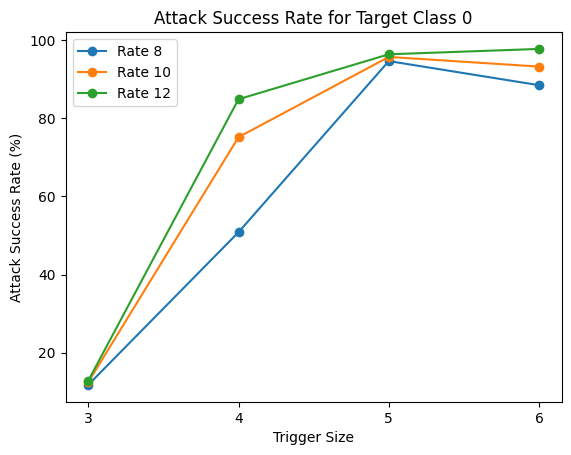

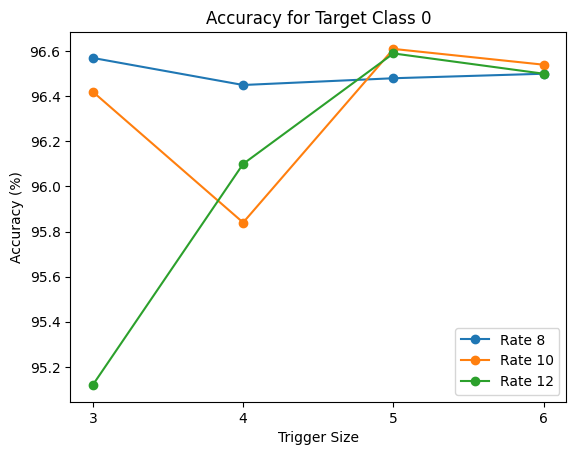

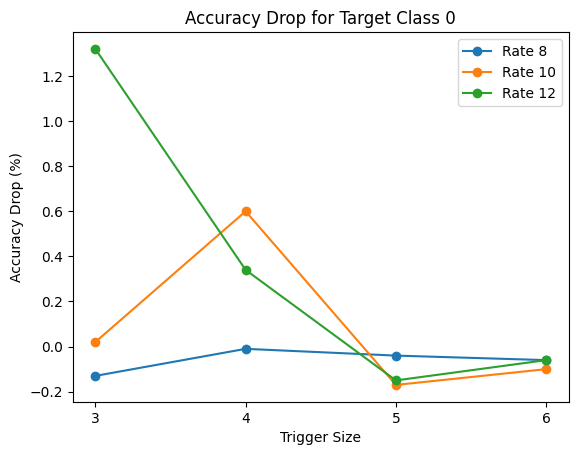

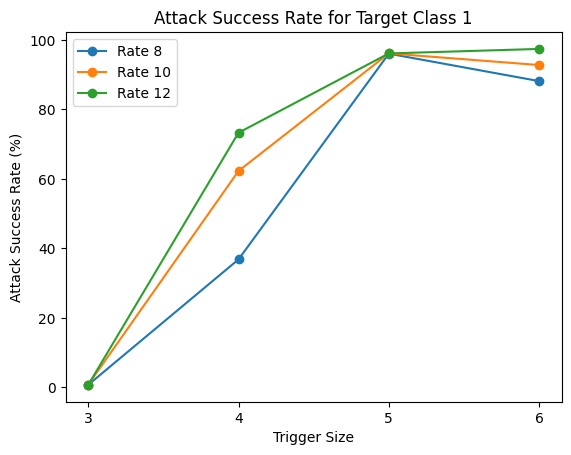

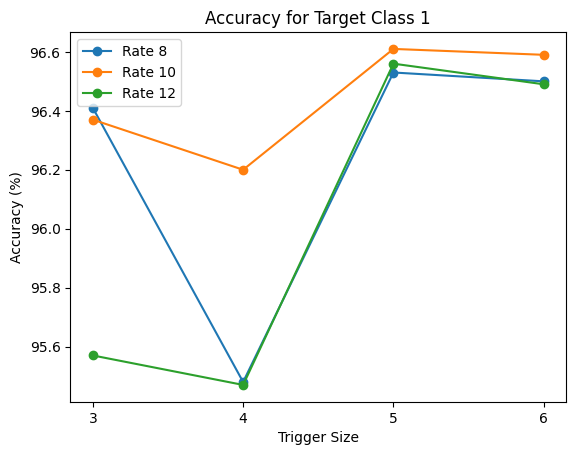

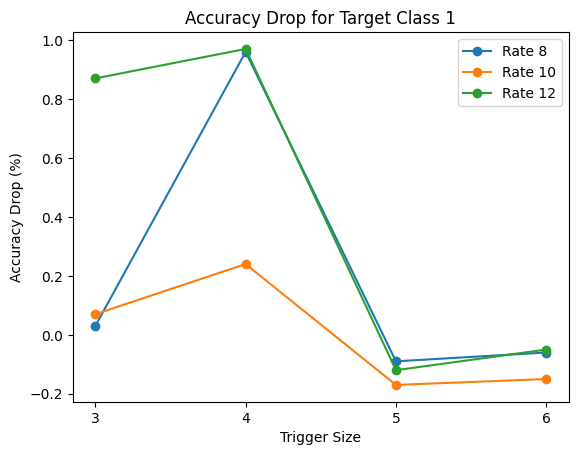

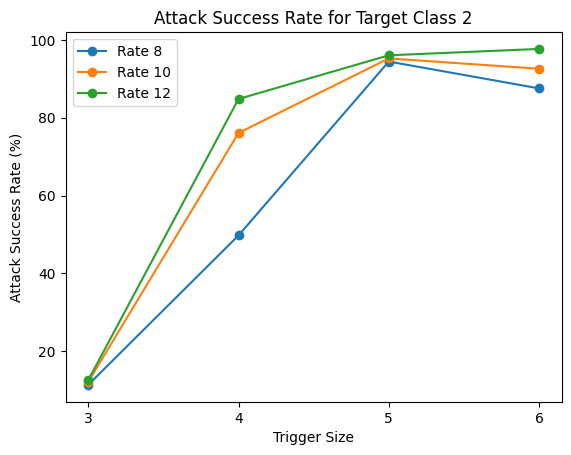

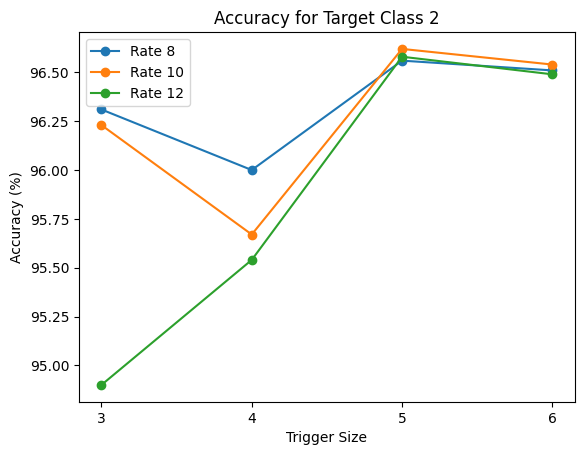

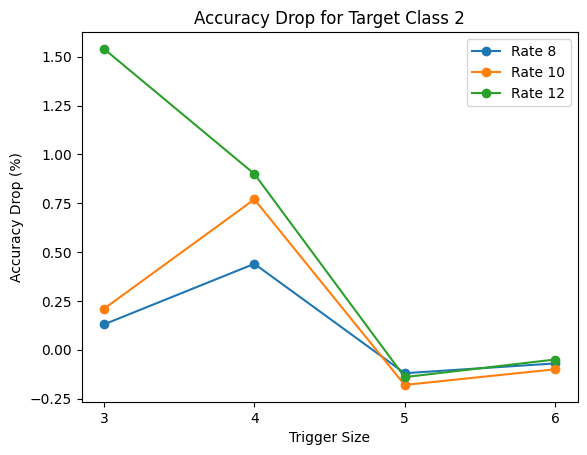

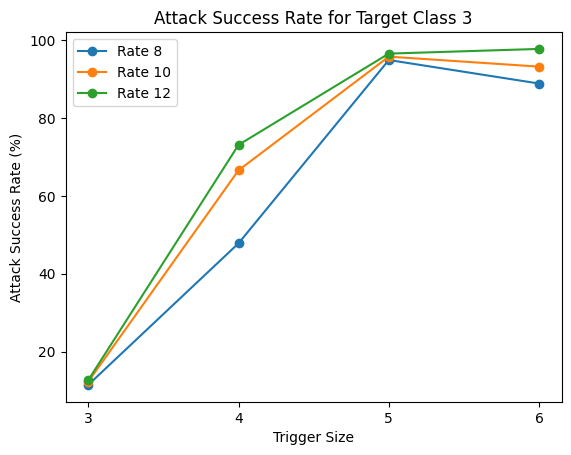

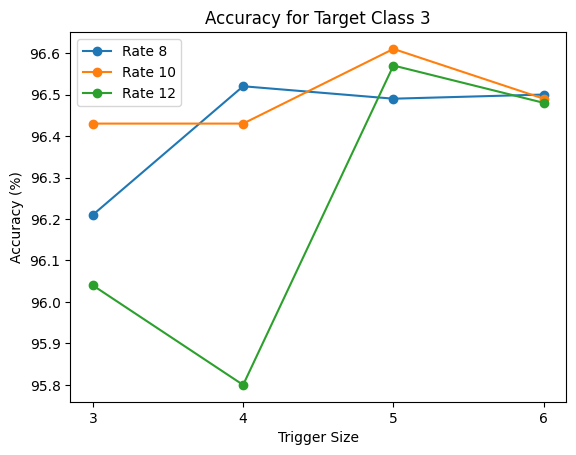

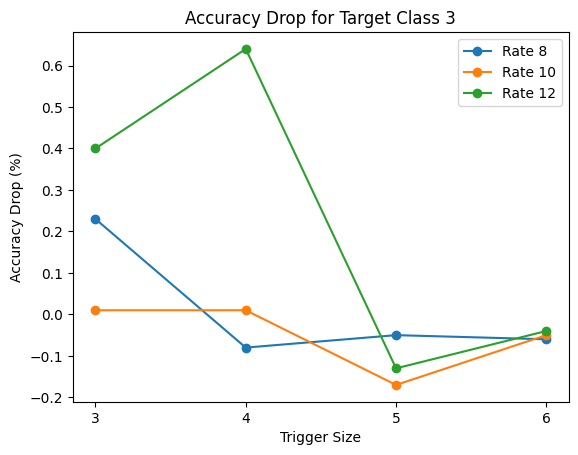

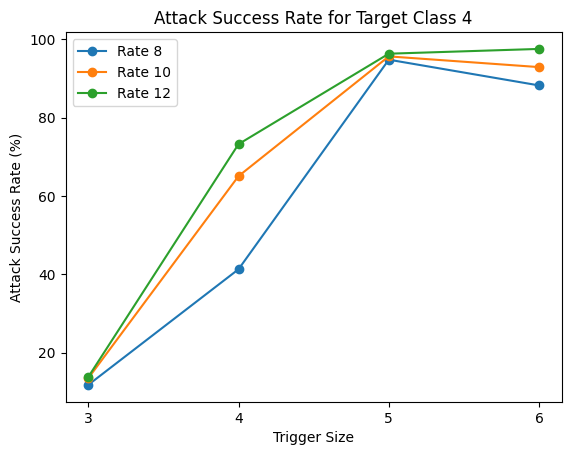

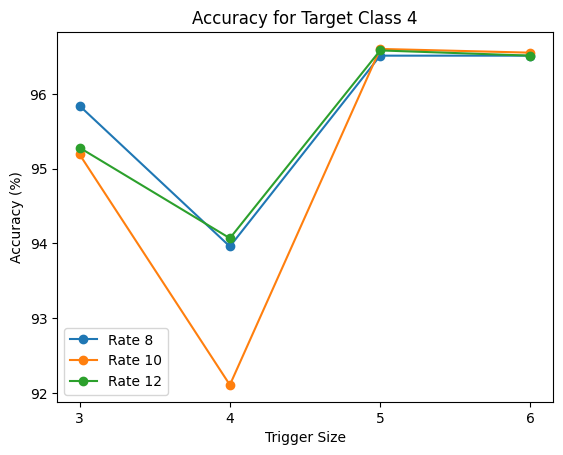

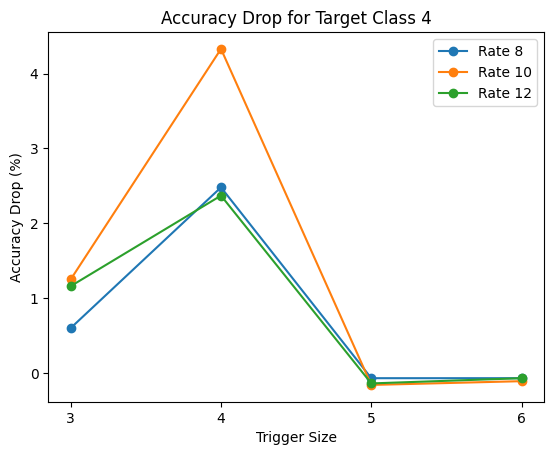

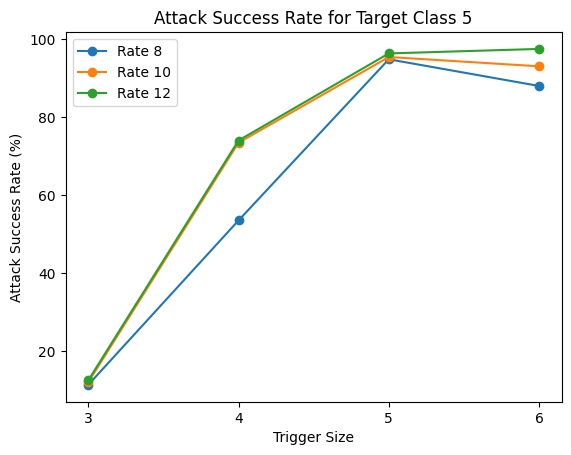

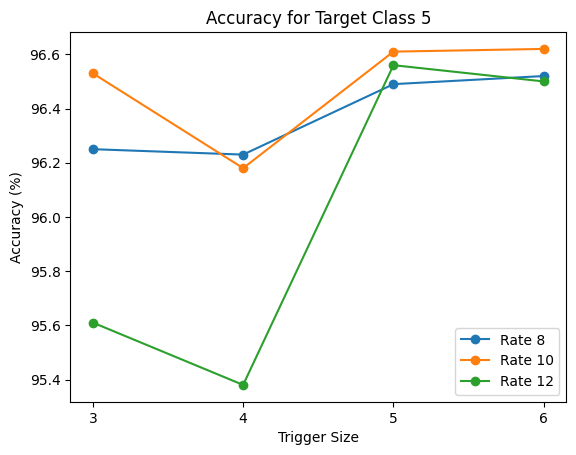

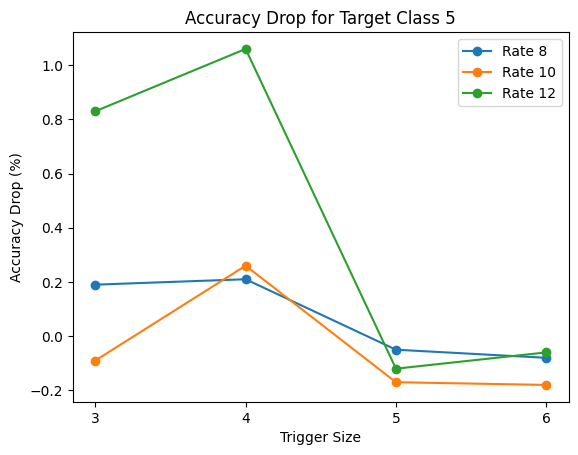

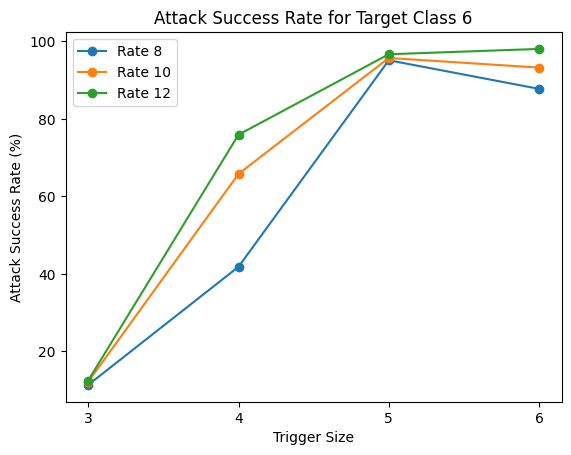

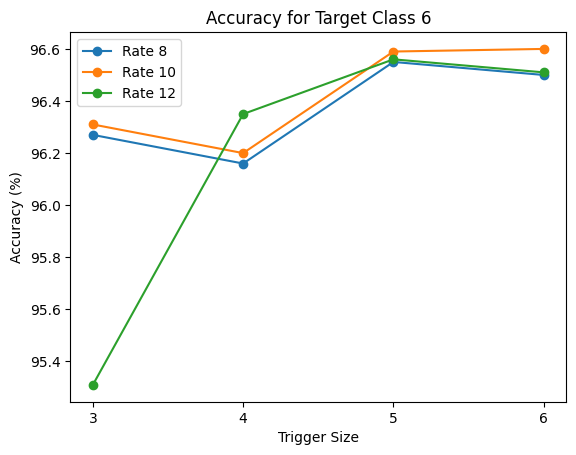

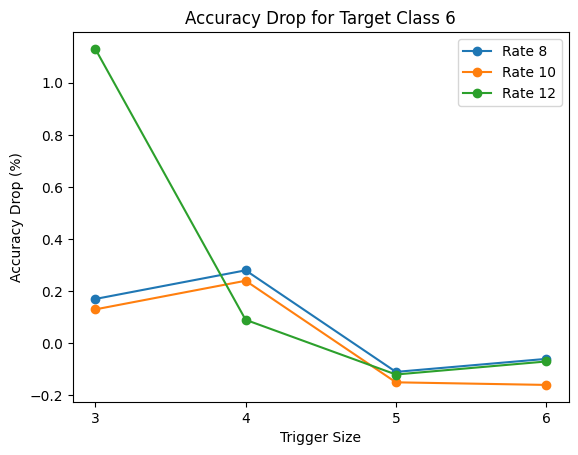

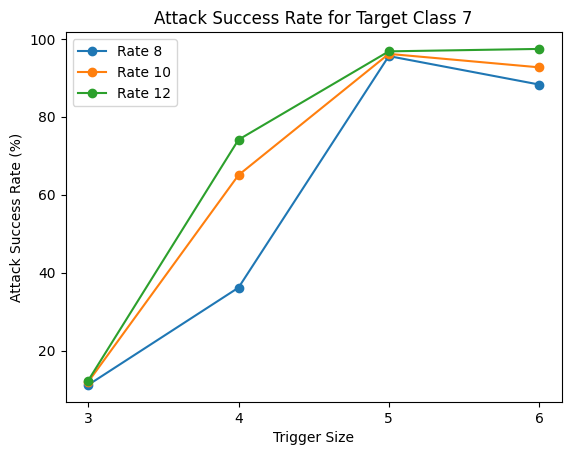

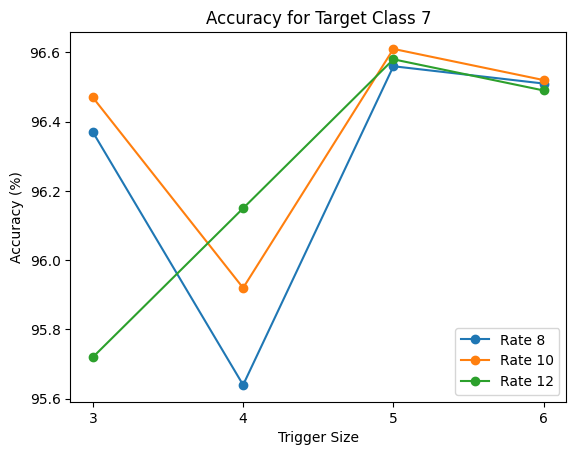

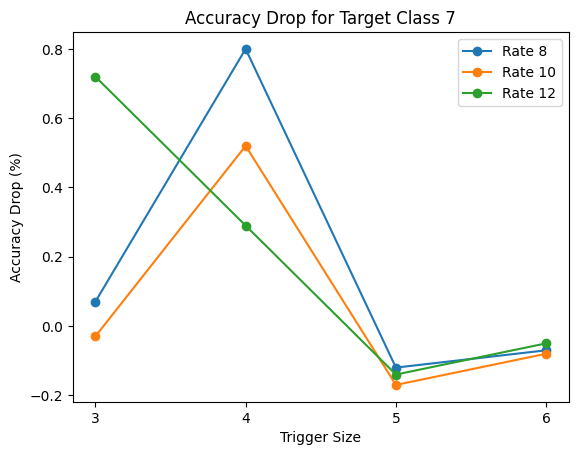

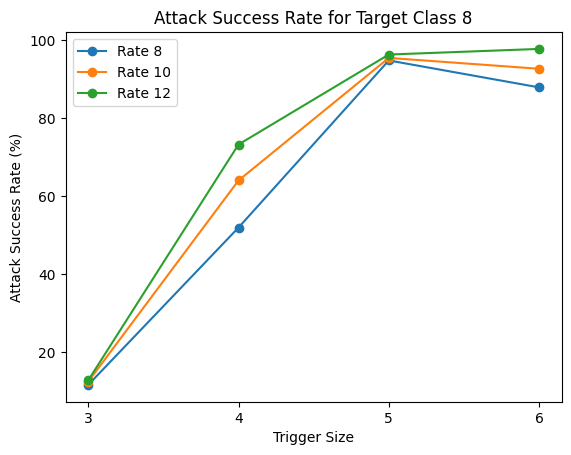

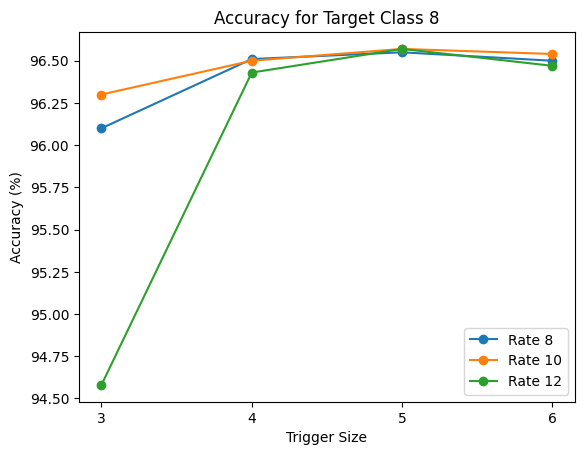

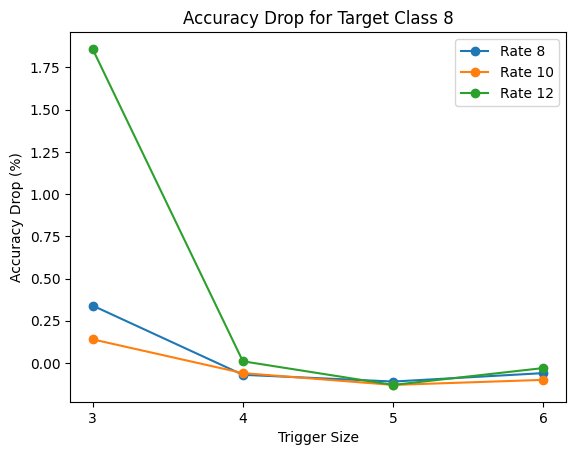

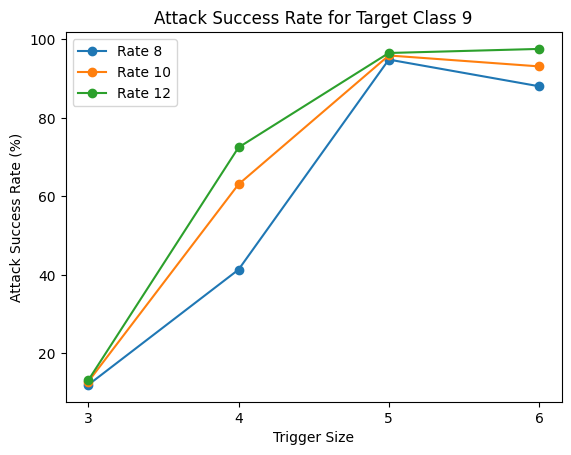

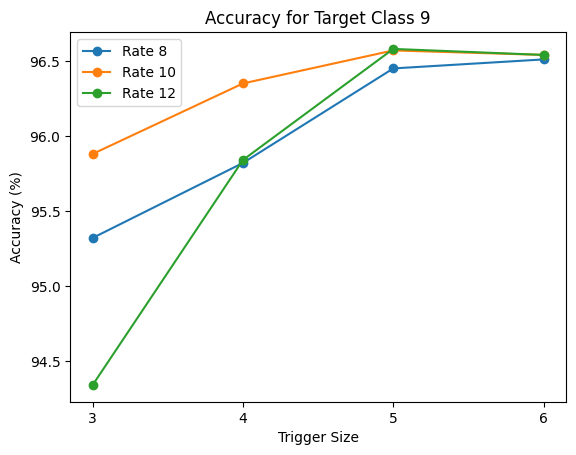

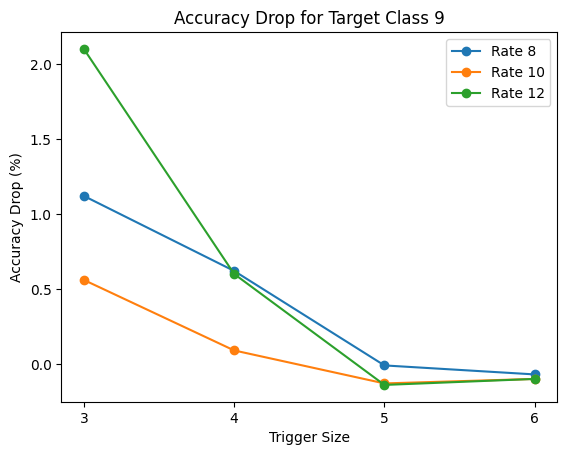

In [ ]:
for i in range(10):
  for j in ['asr', "acc", "acc_drop"]:
    plot_metric(results_mnist_dirty, i, j)